# RegressorChain for Mass Spectrometry Prediction


We explore RegressorChain with RandomForest to exploit mass spectral dependencies: isotope patterns, fragmentation correlations, and adduct relationships. The approach predicts m/z bins sequentially, using prior predictions as features to capture conditional peak relationships.

## Problem setup
- Input features: $\mathbf{x}\in\mathbb{R}^{7137}$
- Target spectrum: $\mathbf{y}\in\mathbb{R}_{\ge 0}^{500}$ with $\mathbf{y}=\sqrt{\tilde{\mathbf{y}}}$
- Primary metric: cosine similarity; secondary: MSE/MAE/$R^2$/peak F1; regional m/z analysis
- Key insight: **Strong isotope patterns detected** in consecutive bins 11-19 with correlations up to 0.702

```mermaid
flowchart LR
  X["Features x (7137)"] --> RC["RegressorChain"]
  RC --> S["Sequential m/z prediction"]
  S --> Y["ŷ ∈ R_+^{500}"]
  Y --> M["Metrics: cosine/F1/MSE"]
  Y --> R["Regional m/z & isotope analysis"]
```

## Implemented architectures
- **Basic RegressorChain**: Standard sequential prediction with RandomForest
- **Isotope-aware ordering**: Processes correlated isotope groups together
- **Hybrid approach**: RegressorChain for correlated regions, MultiOutput for independent bins
- **Advanced chain strategies**: Correlation-based, variance-based, and isotope-aware ordering

Key techniques: Sequential feature augmentation, isotope pattern exploitation, hybrid modeling, computational optimization.

## 0. Environment Setup

In [1]:
# Standard library imports
import os
import json
import pickle
import time
import warnings
import io
from typing import Dict, Any, Tuple, List, Optional
import gc
import multiprocessing

# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from tqdm import tqdm
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr

# Machine learning imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# Chemistry imports (optional)
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    from rdkit.Chem.Draw import rdMolDraw2D
    RDKIT_AVAILABLE = True
    print("RDKit available for molecular structure visualization")
except ImportError:
    RDKIT_AVAILABLE = False
    print("Warning: RDKit not available. Molecular structure features will be limited.")

# Configure warnings and display
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set random seeds
SEED = 42
np.random.seed(SEED)

# Get number of CPU cores
N_CORES = multiprocessing.cpu_count()
print(f"Number of CPU cores available: {N_CORES}")

# Configure matplotlib
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# Colorblind-friendly Okabe–Ito palette for standard plots
PALETTE = {
    "blue": "#0072B2",
    "sky": "#56B4E9",
    "orange": "#E69F00",
    "vermillion": "#D55E00",
    "yellow": "#F0E442",
    "green": "#009E73",
    "purple": "#CC79A7",
    "black": "#000000",
    "grey": "#999999",
}

print("Environment setup complete")

RDKit available for molecular structure visualization
Number of CPU cores available: 16
Environment setup complete


## 1. Configuration Management

In [2]:
CONFIG = {
    # Data paths
    'paths': {
        'results_dir': '../data/results',
        'models_dir': '../models/regressor_chain',
        'input_type': 'hpj',
        'use_selected_data': False,
        'data_subdir': lambda use_sel: 'selected' if use_sel else 'full_featurised'
    },
    
    # Data settings
    'data': {
        'random_state': 42,
        'transform_sqrt': True,
        'subsample_size': 10000,  # Use subset for faster experimentation
        'mz_min': 0,  # Minimum m/z value
        'mz_max': 500,  # Maximum m/z value (adjust based on your data)
        'mz_bins': 501  # Number of m/z bins (should match your data)
    },
    
    # RandomForest base parameters - OPTIMIZED FOR CHAINING
    'rf_base': {
        'n_estimators': 100,  # Increased for better performance
        'max_depth': 15,  # Reduced to prevent overfitting on chain features
        'min_samples_split': 10,  # Increased for regularization
        'min_samples_leaf': 5,  # Increased for regularization
        'max_features': 'sqrt',
        'n_jobs': 1,  # Set to 1 since RegressorChain will parallelize
        'random_state': SEED
    },
    
    # RegressorChain parameters
    'chain': {
        'orders': ['default', 'random', 'correlation', 'variance', 'isotope', 'hybrid'],
        'cv_chain': False,  # Whether to use CV to determine order
        'random_state': SEED,
        'correlation_threshold': 0.2,  # Threshold for high correlation
        'isotope_correlation_threshold': 0.3  # Threshold for isotope patterns
    },
    
    # Known isotope regions from analysis
    'isotope_regions': [
        (11, 19),  # Strong isotope pattern region
        (23, 24)   # Another isotope pair
    ],
    
    # Evaluation settings
    'evaluation': {
        'mz_regions': {
            'low': (0, 100),
            'medium': (100, 300),
            'high': (300, 500)
        },
        'top_k_peaks': 20,  # Analyze top K most intense peaks
        'mz_step': 50,  # For standard plots
        'max_mz': 1000,  # For standard plots
        'peak_threshold': 0.01  # For peak detection metrics
    }
}

# Create models directory
os.makedirs(CONFIG['paths']['models_dir'], exist_ok=True)

print("Configuration loaded")
print(f"Models will be saved to: {CONFIG['paths']['models_dir']}")
print(f"Identified isotope regions: {CONFIG['isotope_regions']}")

Configuration loaded
Models will be saved to: ../models/regressor_chain
Identified isotope regions: [(11, 19), (23, 24)]


## 2. Data Management

In [3]:
def get_data_paths(config):
    """Get data file paths based on configuration."""
    input_type_dir = os.path.join(config['paths']['results_dir'], config['paths']['input_type'])
    data_dir = os.path.join(input_type_dir, config['paths']['data_subdir'](config['paths']['use_selected_data']))
    
    return {
        'train': os.path.join(data_dir, 'train_data.jsonl'),
        'val': os.path.join(data_dir, 'val_data.jsonl'),
        'test': os.path.join(data_dir, 'test_data.jsonl')
    }

def load_jsonl_data(filepath, max_samples=None):
    """Load data from JSONL file with optional subsampling."""
    smiles_list, features, targets = [], [], []
    
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return smiles_list, np.array(features), np.array(targets)
    
    # Count lines
    with open(filepath, 'r') as f:
        total_lines = sum(1 for _ in f)
    
    # Determine samples to load
    n_samples = min(max_samples, total_lines) if max_samples else total_lines
    
    with open(filepath, 'r') as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading {os.path.basename(filepath)}", 
                                     total=n_samples, unit="spectra")):
            if i >= n_samples:
                break
                
            try:
                record = json.loads(line)
                smiles = record.get("smiles")
                feat = record.get("features")
                targ = record.get("target")
                
                if smiles and feat is not None and targ is not None:
                    smiles_list.append(smiles)
                    features.append(feat)
                    targets.append(targ)
            except (json.JSONDecodeError, KeyError) as e:
                continue
    
    print(f"Loaded {len(smiles_list)} samples from {os.path.basename(filepath)}")
    return smiles_list, np.array(features), np.array(targets)

def cosine_similarity_matrix(y_true, y_pred):
    """Calculate cosine similarity between true and predicted spectra."""
    similarities = []
    for i in range(len(y_true)):
        true_spec = y_true[i]
        pred_spec = y_pred[i]
        
        if np.sum(true_spec) == 0 or np.sum(pred_spec) == 0:
            cos_sim = 0 if np.sum(true_spec) != np.sum(pred_spec) else 1
        else:
            cos_sim = 1 - cosine(true_spec, pred_spec)
        
        similarities.append(cos_sim if not np.isnan(cos_sim) else 0)
    
    return np.mean(similarities), np.array(similarities)

# Load data
print("\nLoading data...")
paths = get_data_paths(CONFIG)

# Load with subsampling for faster experimentation
train_smiles, X_train, y_train = load_jsonl_data(
    paths['train'], 
    max_samples=CONFIG['data']['subsample_size']
)
test_smiles, X_test, y_test = load_jsonl_data(
    paths['test'], 
    max_samples=CONFIG['data']['subsample_size'] // 5
)

# Apply transformation
if CONFIG['data']['transform_sqrt']:
    y_train_transformed = np.sqrt(y_train)
    y_test_transformed = np.sqrt(y_test)
    print("Applied square root transformation to targets")
else:
    y_train_transformed = y_train
    y_test_transformed = y_test

# Apply feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Update config with actual number of bins
CONFIG['data']['mz_bins'] = y_train_transformed.shape[1]

print(f"\nData shapes:")
print(f"X_train: {X_train_scaled.shape}")
print(f"y_train: {y_train_transformed.shape}")
print(f"X_test: {X_test_scaled.shape}")
print(f"y_test: {y_test_transformed.shape}")
print(f"\nNumber of m/z bins: {y_train_transformed.shape[1]}")


Loading data...


Loading train_data.jsonl: 100%|██████████| 2176/2176 [00:01<00:00, 2006.67spectra/s]


Loaded 2176 samples from train_data.jsonl


Loading test_data.jsonl: 100%|██████████| 272/272 [00:00<00:00, 2196.30spectra/s]


Loaded 272 samples from test_data.jsonl
Applied square root transformation to targets

Data shapes:
X_train: (2176, 7137)
y_train: (2176, 500)
X_test: (272, 7137)
y_test: (272, 500)

Number of m/z bins: 500


## 3. Standard Visualization Module

Standard plotting suite for mass spectrometry models.

In [4]:
# ============================================================================
# STANDARD EVALUATION AND VISUALIZATION FUNCTIONS
# ============================================================================

def weighted_dot_product(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-8) -> float:
    """Calculate weighted dot product (WDP) score."""
    weights = y_true + eps
    numerator = np.sum(weights * y_true * y_pred)
    denominator = np.sum(weights * y_true * y_true) + eps
    return numerator / denominator

def peak_detection_metrics(y_true: np.ndarray, y_pred: np.ndarray, threshold: float = 0.01) -> Dict:
    """Calculate peak detection metrics."""
    # Normalize to relative intensities
    y_true_norm = y_true / (np.max(y_true, axis=1, keepdims=True) + 1e-8)
    y_pred_norm = y_pred / (np.max(y_pred, axis=1, keepdims=True) + 1e-8)
    
    # Binary masks for peaks
    true_peaks = y_true_norm > threshold
    pred_peaks = y_pred_norm > threshold
    
    # Calculate metrics
    tp = np.sum(true_peaks & pred_peaks)
    fp = np.sum(~true_peaks & pred_peaks)
    fn = np.sum(true_peaks & ~pred_peaks)
    
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'true_peaks': np.sum(true_peaks),
        'pred_peaks': np.sum(pred_peaks),
        'tp': tp,
        'fp': fp,
        'fn': fn
    }

def get_model_predictions_with_uncertainty(model, X_scaled):
    """Get predictions with model uncertainty from Random Forest-based models."""
    if hasattr(model, 'estimators_'):  # MultiOutputRegressor with RF
        # Get predictions from each output's trees
        all_predictions = []
        for estimator in model.estimators_:
            if hasattr(estimator, 'estimators_'):  # It's a RandomForest
                tree_preds = np.array([tree.predict(X_scaled) for tree in estimator.estimators_])
                all_predictions.append(tree_preds)
        if all_predictions:
            # Stack and reorganize: (n_trees, n_samples, n_outputs)
            tree_predictions = np.stack(all_predictions, axis=2).transpose(0, 1, 2)
            y_pred = np.mean(tree_predictions, axis=0)
            return y_pred, tree_predictions
    elif hasattr(model, 'estimators_'):  # RegressorChain
        # For RegressorChain, we can't easily get tree-level predictions
        y_pred = model.predict(X_scaled)
        return y_pred, None
    else:
        # Fallback
        y_pred = model.predict(X_scaled)
        return y_pred, None

def cosine_similarity_by_mz_range(y_true, y_pred, config):
    """Calculate cosine similarity by m/z range."""
    spectrum_length = y_true.shape[1]
    step_size = config['evaluation']['mz_step']
    max_mz = min(config['evaluation']['max_mz'], spectrum_length)
    
    mz_ranges = {}
    for start in range(0, max_mz, step_size):
        end = min(start + step_size, max_mz)
        range_key = f"{start}-{end}"
        
        y_true_range = y_true[:, start:end]
        y_pred_range = y_pred[:, start:end]
        
        # Calculate cosine similarities
        similarities = []
        for i in range(len(y_true)):
            true_spec = y_true_range[i]
            pred_spec = y_pred_range[i]
            
            if np.sum(true_spec) == 0 or np.sum(pred_spec) == 0:
                sim = 0 if np.sum(true_spec) != np.sum(pred_spec) else 1
            else:
                sim = 1 - cosine(true_spec, pred_spec)
            similarities.append(sim)
        
        mean_sim = np.mean(similarities)
        
        # Statistical uncertainty (across samples)
        stat_uncertainty = np.std(similarities) / np.sqrt(len(similarities)) if len(similarities) > 1 else 0
        
        # For non-RF models, we don't have model uncertainty
        model_uncertainty = 0
        
        # Peak counting
        true_peaks = np.sum(y_true_range > config['evaluation']['peak_threshold'])
        pred_peaks = np.sum(y_pred_range > config['evaluation']['peak_threshold'])
        
        # Coverage
        non_zero_samples = np.sum(np.sum(y_true_range, axis=1) > 0)
        coverage = non_zero_samples / len(y_true) * 100
        
        mz_ranges[range_key] = {
            'mean_similarity': mean_sim,
            'stat_uncertainty': stat_uncertainty,
            'model_uncertainty': model_uncertainty,
            'coverage': coverage,
            'avg_true_peaks_per_spectrum': true_peaks / len(y_true),
            'avg_pred_peaks_per_spectrum': pred_peaks / len(y_true)
        }
    
    return mz_ranges

def plot_standard_2x2_diagnostic(results: Dict, model_name: str = "Model", show_uncertainties: bool = False):
    """Create standard 2x2 evaluation visualization."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # ---------- Top-Left: Cosine Similarity Distribution ----------
    ax = axes[0, 0]
    ax.hist(results['individual_cos_sims'], bins=30, range=(0, 1),
            alpha=0.85, color=PALETTE["blue"], edgecolor=PALETTE["black"], linewidth=0.5)
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Count')
    ax.set_title(f'Cosine Similarity Distribution - {model_name}')
    ax.axvline(results['cosine_similarity'], color=PALETTE["vermillion"], linestyle='--', linewidth=2,
               label=f"Mean: {results['cosine_similarity']:.4f}")
    ax.legend(frameon=False)
    ax.grid(alpha=0.3)
    
    # ---------- Top-Right: Performance by m/z Range ----------
    ax = axes[0, 1]
    ranges = list(results['mz_range_sims'].keys())
    x_pos = np.arange(len(ranges))
    mean_sims = np.array([results['mz_range_sims'][r]['mean_similarity'] for r in ranges])
    stat_uncertainties = np.array([results['mz_range_sims'][r]['stat_uncertainty'] for r in ranges])
    model_uncertainties = np.array([results['mz_range_sims'][r]['model_uncertainty'] for r in ranges])
    
    if show_uncertainties and np.any(stat_uncertainties > 0):
        # Calculate confidence intervals
        stat_ci = 1.96 * stat_uncertainties
        model_sigma = 2.0 * model_uncertainties
        
        stat_lower = np.clip(mean_sims - stat_ci, 0, 1)
        stat_upper = np.clip(mean_sims + stat_ci, 0, 1)
        model_lower = np.clip(mean_sims - model_sigma, 0, 1)
        model_upper = np.clip(mean_sims + model_sigma, 0, 1)
        
        # Model uncertainty: translucent band + dotted bounds
        if np.any(model_uncertainties > 0):
            ax.fill_between(x_pos, model_lower, model_upper,
                            facecolor=PALETTE["purple"], alpha=0.18,
                            edgecolor=PALETTE["purple"], linewidth=0.8, zorder=1)
            ax.plot(x_pos, model_lower, linestyle=':', color=PALETTE["purple"], linewidth=1.3, zorder=2)
            ax.plot(x_pos, model_upper, linestyle=':', color=PALETTE["purple"], linewidth=1.3, zorder=2)
        
        # Statistical uncertainty: hatched band
        ax.fill_between(x_pos, stat_lower, stat_upper,
                        facecolor='none', edgecolor=PALETTE["yellow"],
                        hatch='////', linewidth=1.2, zorder=3)
        ax.plot(x_pos, stat_lower, linestyle='--', color=PALETTE["yellow"], linewidth=1.2, zorder=4)
        ax.plot(x_pos, stat_upper, linestyle='--', color=PALETTE["yellow"], linewidth=1.2, zorder=4)
    
    ax.plot(x_pos, mean_sims, color=PALETTE["blue"], linewidth=2.5,
            label='Mean Cosine Similarity', marker='o', markersize=6, zorder=5)
    ax.set_xlabel('m/z Range')
    ax.set_ylabel('Cosine Similarity')
    ax.set_title(f'Performance by m/z Range - {model_name}')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(ranges, rotation=45)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(alpha=0.3)
    if show_uncertainties:
        ax.legend(handles=[
            Patch(facecolor=PALETTE["purple"], alpha=0.18, edgecolor=PALETTE["purple"],
                  label='Model Uncertainty (±2σ)'),
            Patch(facecolor='none', edgecolor=PALETTE["yellow"], hatch='////',
                  label='Statistical Uncertainty (95% CI)')
        ], loc='lower left', fontsize=9, frameon=False)
    
    # ---------- Bottom-Left: True vs Predicted Intensity with Violin Density ----------
    ax = axes[1, 0]
    y_true_flat = np.ravel(results['y_true']).astype(float)
    y_pred_flat = np.ravel(results['y_pred']).astype(float)
    m = np.isfinite(y_true_flat) & np.isfinite(y_pred_flat)
    x = y_true_flat[m]
    y = y_pred_flat[m]
    
    # Rotate to (u,v) coordinates for violin visualization
    root2 = np.sqrt(2.0)
    u = (x + y) / root2
    v = (y - x) / root2
    
    # Bin along diagonal and compute quantiles
    n_bins = 60
    u_edges = np.linspace(u.min(), u.max(), n_bins + 1)
    u_centers = 0.5 * (u_edges[:-1] + u_edges[1:])
    widths_90 = np.full(n_bins, np.nan)
    widths_75 = np.full(n_bins, np.nan)
    widths_60 = np.full(n_bins, np.nan)
    min_count = 10
    
    for i in range(n_bins):
        mask = (u >= u_edges[i]) & (u < u_edges[i+1])
        if np.count_nonzero(mask) >= min_count:
            abs_v = np.abs(v[mask])
            widths_60[i] = np.percentile(abs_v, 60)
            widths_75[i] = np.percentile(abs_v, 75)
            widths_90[i] = np.percentile(abs_v, 90)
    
    # Interpolate and smooth
    def _interp_nan(a):
        xidx = np.arange(a.size)
        msk = ~np.isnan(a)
        if msk.sum() < 2:
            return np.nan_to_num(a, nan=0.0)
        return np.interp(xidx, xidx[msk], a[msk])
    
    def _smooth(a, k=5):
        if k <= 1: return a
        kernel = np.ones(k) / k
        return np.convolve(a, kernel, mode='same')
    
    widths_60 = _smooth(_interp_nan(widths_60), 5)
    widths_75 = _smooth(_interp_nan(widths_75), 5)
    widths_90 = _smooth(_interp_nan(widths_90), 5)
    
    def band_polygon(u_vals, w_vals):
        x_upper = (u_vals - w_vals) / root2
        y_upper = (u_vals + w_vals) / root2
        x_lower = (u_vals + w_vals) / root2
        y_lower = (u_vals - w_vals) / root2
        x_poly = np.r_[x_upper, x_lower[::-1]]
        y_poly = np.r_[y_upper, y_lower[::-1]]
        return x_poly, y_poly
    
    # Scatter points
    ax.scatter(x, y, s=4, marker='.', color=PALETTE["black"],
               edgecolors='none', alpha=1.0, zorder=0, rasterized=True)
    
    # Draw violin bands
    for w, a in [(widths_90, 0.25), (widths_75, 0.35), (widths_60, 0.5)]:
        xp, yp = band_polygon(u_centers, w)
        ax.fill(xp, yp, color=PALETTE["sky"], alpha=a, edgecolor='none', zorder=2)
    
    # Perfect prediction line - FIXED: Clip at 1.0 for normalized intensities
    max_val = 1.0  # Fixed to 1.0 for normalized intensities
    line_pp, = ax.plot([0, max_val], [0, max_val], color=PALETTE["vermillion"],
                       linestyle='--', linewidth=1.6, label='Perfect Prediction', zorder=4)
    
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel('True Intensity')
    ax.set_ylabel('Predicted Intensity')
    ax.set_title(f'Intensity Correlation - {model_name}')
    
    # Legend
    violin_handle = Patch(facecolor=PALETTE["sky"], alpha=0.35, edgecolor='none', label='Density (violin)')
    points_handle = Line2D([0], [0], linestyle='none', marker='.', markersize=6,
                           color=PALETTE["black"], label='All points')
    ax.legend(handles=[points_handle, violin_handle, line_pp], loc='lower right',
              frameon=True, facecolor='white', framealpha=0.85, edgecolor='none', handlelength=2.2)
    ax.grid(alpha=0.25)
    
    # Metrics annotation
    text = f"R² = {results['r2']:.4f}\nMAE = {results['mae']:.4f}"
    ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=11,
            va='top', bbox=dict(boxstyle='round', facecolor='wheat',
            alpha=0.6, edgecolor='none'), zorder=5)
    
    # ---------- Bottom-Right: Peak Count Comparison ----------
    ax = axes[1, 1]
    true_peaks = [results['mz_range_sims'][r]['avg_true_peaks_per_spectrum'] for r in ranges]
    pred_peaks = [results['mz_range_sims'][r]['avg_pred_peaks_per_spectrum'] for r in ranges]
    width = 0.35
    
    bars1 = ax.bar(x_pos - width/2, true_peaks, width, label='True',
                   color=PALETTE["green"], alpha=0.9, edgecolor=PALETTE["black"], linewidth=0.6)
    bars2 = ax.bar(x_pos + width/2, pred_peaks, width, label='Predicted',
                   color=PALETTE["blue"],  alpha=0.9, edgecolor=PALETTE["black"], linewidth=0.6)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            h = bar.get_height()
            if h > 0:
                ax.text(bar.get_x() + bar.get_width()/2., h, f'{h:.0f}',
                        ha='center', va='bottom', fontsize=12)
    
    ax.set_xlabel('m/z Range')
    ax.set_ylabel('Average Peaks per Spectrum')
    ax.set_title(f'Peak Count Comparison - {model_name}')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(ranges, rotation=45)
    ax.legend(frameon=False)
    ax.grid(alpha=0.3)
    
    plt.suptitle(f'Standard Diagnostic Suite: {model_name}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_random_spectrum_grid(results: Dict, test_smiles: List, n_examples: int = 4, model_name: str = "Model"):
    """Create 2x2 grid of random spectrum examples with molecular structures."""
    # Select random examples
    n_samples = len(results['y_true'])
    random_indices = np.random.choice(n_samples, min(n_examples, n_samples), replace=False)
    
    # Calculate metrics for selected examples
    selected_data = []
    for idx in random_indices:
        y_true = results['y_true'][idx]
        y_pred = results['y_pred'][idx]
        
        # Calculate cosine similarity
        if np.sum(y_true) == 0 and np.sum(y_pred) == 0:
            cosine_sim = 1.0
        elif np.sum(y_true) == 0 or np.sum(y_pred) == 0:
            cosine_sim = 0.0
        else:
            cosine_sim = 1 - cosine(y_true, y_pred)
        
        # Calculate WDP score
        wdp_score = weighted_dot_product(y_true, y_pred)
        
        # Get SMILES
        smiles = test_smiles[idx] if idx < len(test_smiles) else 'N/A'
        
        selected_data.append({
            'y_true': y_true,
            'y_pred': y_pred,
            'cosine_sim': cosine_sim,
            'wdp_score': wdp_score,
            'smiles': smiles,
            'index': idx
        })
    
    # Create figure
    fig = plt.figure(figsize=(20, 16))
    main_gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    print(f"\nSelected random examples:")
    
    for i, data in enumerate(selected_data[:4]):
        print(f"  {i+1}. Index {data['index']}: Cosine={data['cosine_sim']:.4f}, WDP={data['wdp_score']:.4f}")
        
        # Calculate position in 2x2 grid
        row = i // 2
        col = i % 2
        
        # Create sub-gridspec for this molecule
        sub_gs = gridspec.GridSpecFromSubplotSpec(2, 1, main_gs[row, col], 
                                                 height_ratios=[1, 1], hspace=0)
        
        ax1 = fig.add_subplot(sub_gs[0])  # Experimental
        ax2 = fig.add_subplot(sub_gs[1])  # Predicted
        
        # Process data (convert from sqrt scale if needed)
        y_true_scaled = data['y_true'] ** 2 if CONFIG['data']['transform_sqrt'] else data['y_true']
        y_pred_scaled = data['y_pred'] ** 2 if CONFIG['data']['transform_sqrt'] else data['y_pred']
        
        # Normalize to 0-100 scale
        if np.max(y_true_scaled) > 0:
            y_true_percent = (y_true_scaled / np.max(y_true_scaled)) * 100
        else:
            y_true_percent = y_true_scaled
            
        if np.max(y_pred_scaled) > 0:
            y_pred_percent = (y_pred_scaled / np.max(y_pred_scaled)) * 100
        else:
            y_pred_percent = y_pred_scaled
        
        # Find non-zero peaks for x-axis range
        mz_values = np.arange(len(data['y_true']))
        threshold = 0.1
        true_nonzero = y_true_percent > threshold
        pred_nonzero = y_pred_percent > threshold
        
        all_nonzero = true_nonzero | pred_nonzero
        if np.any(all_nonzero):
            nonzero_indices = np.where(all_nonzero)[0]
            min_mz = nonzero_indices[0]
            max_mz = nonzero_indices[-1]
            mz_range = max_mz - min_mz
            padding = max(10, int(0.05 * mz_range))
            x_min = max(0, min_mz - padding)
            x_max = min(len(data['y_true']), max_mz + padding)
        else:
            x_min = 0
            x_max = min(500, len(data['y_true']))
        
        # Top panel: Experimental spectrum
        if np.any(true_nonzero):
            markerline, stemlines, baseline = ax1.stem(
                mz_values[true_nonzero], 
                y_true_percent[true_nonzero],
                linefmt='b-', markerfmt=' ', basefmt=' '
            )
            stemlines.set_linewidth(1)
        
        ax1.set_ylabel('Intensity (%)', fontsize=10)
        ax1.text(0.5, 0.95, 'Experimental', transform=ax1.transAxes,
                 fontsize=11, ha='center', va='top')
        ax1.set_ylim(0, 110)
        ax1.grid(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.tick_params(bottom=False, labelbottom=False)
        
        # Bottom panel: Predicted spectrum (inverted)
        if np.any(pred_nonzero):
            markerline, stemlines, baseline = ax2.stem(
                mz_values[pred_nonzero], 
                -y_pred_percent[pred_nonzero],
                linefmt='r-', markerfmt=' ', basefmt=' '
            )
            stemlines.set_linewidth(1)
        
        ax2.set_ylim(-110, 0)
        ax2.set_ylabel('Intensity (%)', fontsize=10)
        ax2.set_xlabel('m/z (Da)', fontsize=10)
        ax2.text(0.5, 0.05, 'Predicted', transform=ax2.transAxes,
                 fontsize=11, ha='center', va='bottom')
        
        # Format y-axis to show positive values
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{abs(x):.0f}'))
        ax2.grid(False)
        ax2.spines['top'].set_visible(False)
        ax2.axhline(y=0, color='black', linewidth=1)
        
        # Set x-axis limits
        ax1.set_xlim(x_min, x_max)
        ax2.set_xlim(x_min, x_max)
        
        # Add molecular structure if available
        if data['smiles'] != "N/A" and RDKIT_AVAILABLE:
            try:
                mol = Chem.MolFromSmiles(data['smiles'])
                if mol:
                    mw = Descriptors.ExactMolWt(mol)
                    
                    # Create inset for molecular structure
                    axins = inset_axes(ax2, width="35%", height="50%", loc='lower right', 
                                       bbox_to_anchor=(0, 0.15, 1, 1), bbox_transform=ax2.transAxes)
                    
                    # Draw molecule
                    drawer = rdMolDraw2D.MolDraw2DCairo(300, 200)
                    drawer.DrawMolecule(mol)
                    drawer.FinishDrawing()
                    png = drawer.GetDrawingText()
                    bio = io.BytesIO(png)
                    img = plt.imread(bio, format='png')
                    axins.imshow(img)
                    axins.axis('off')
                    
                    # Add molecular weight
                    axins.text(0.5, -0.08, f'MW: {mw:.1f}', transform=axins.transAxes,
                              fontsize=9, ha='center', va='top', fontweight='bold')
            except:
                pass
        
        # Add title with scores
        title = f"Cosine: {data['cosine_sim']:.3f}, WDP: {data['wdp_score']:.3f}"
        ax1.set_title(title, fontsize=11, fontweight='bold')
    
    # Add overall title
    fig.suptitle(f'Random Spectrum Examples - {model_name}', fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print("Standard visualization functions loaded")

Standard visualization functions loaded


## 5. Analyze m/z Correlations and Isotope Patterns

Analyze the correlation structure and identify isotope patterns in the mass spectra.

Calculating m/z correlation matrix...
Number of zero variance m/z bins: 16

Identified 20 isotope pattern groups:
  Bins 11-19: 9 connected bins
  Bins 20-21: 2 connected bins
  Bins 23-32: 10 connected bins
  Bins 35-41: 7 connected bins
  Bins 44-57: 14 connected bins
  Bins 58-71: 14 connected bins
  Bins 73-85: 13 connected bins
  Bins 86-90: 5 connected bins
  Bins 91-99: 9 connected bins
  Bins 100-424: 325 connected bins
  Bins 425-429: 5 connected bins
  Bins 430-437: 8 connected bins
  Bins 440-445: 6 connected bins
  Bins 446-452: 7 connected bins
  Bins 453-464: 12 connected bins
  Bins 466-468: 3 connected bins
  Bins 469-479: 11 connected bins
  Bins 480-482: 3 connected bins
  Bins 484-492: 9 connected bins
  Bins 494-497: 4 connected bins


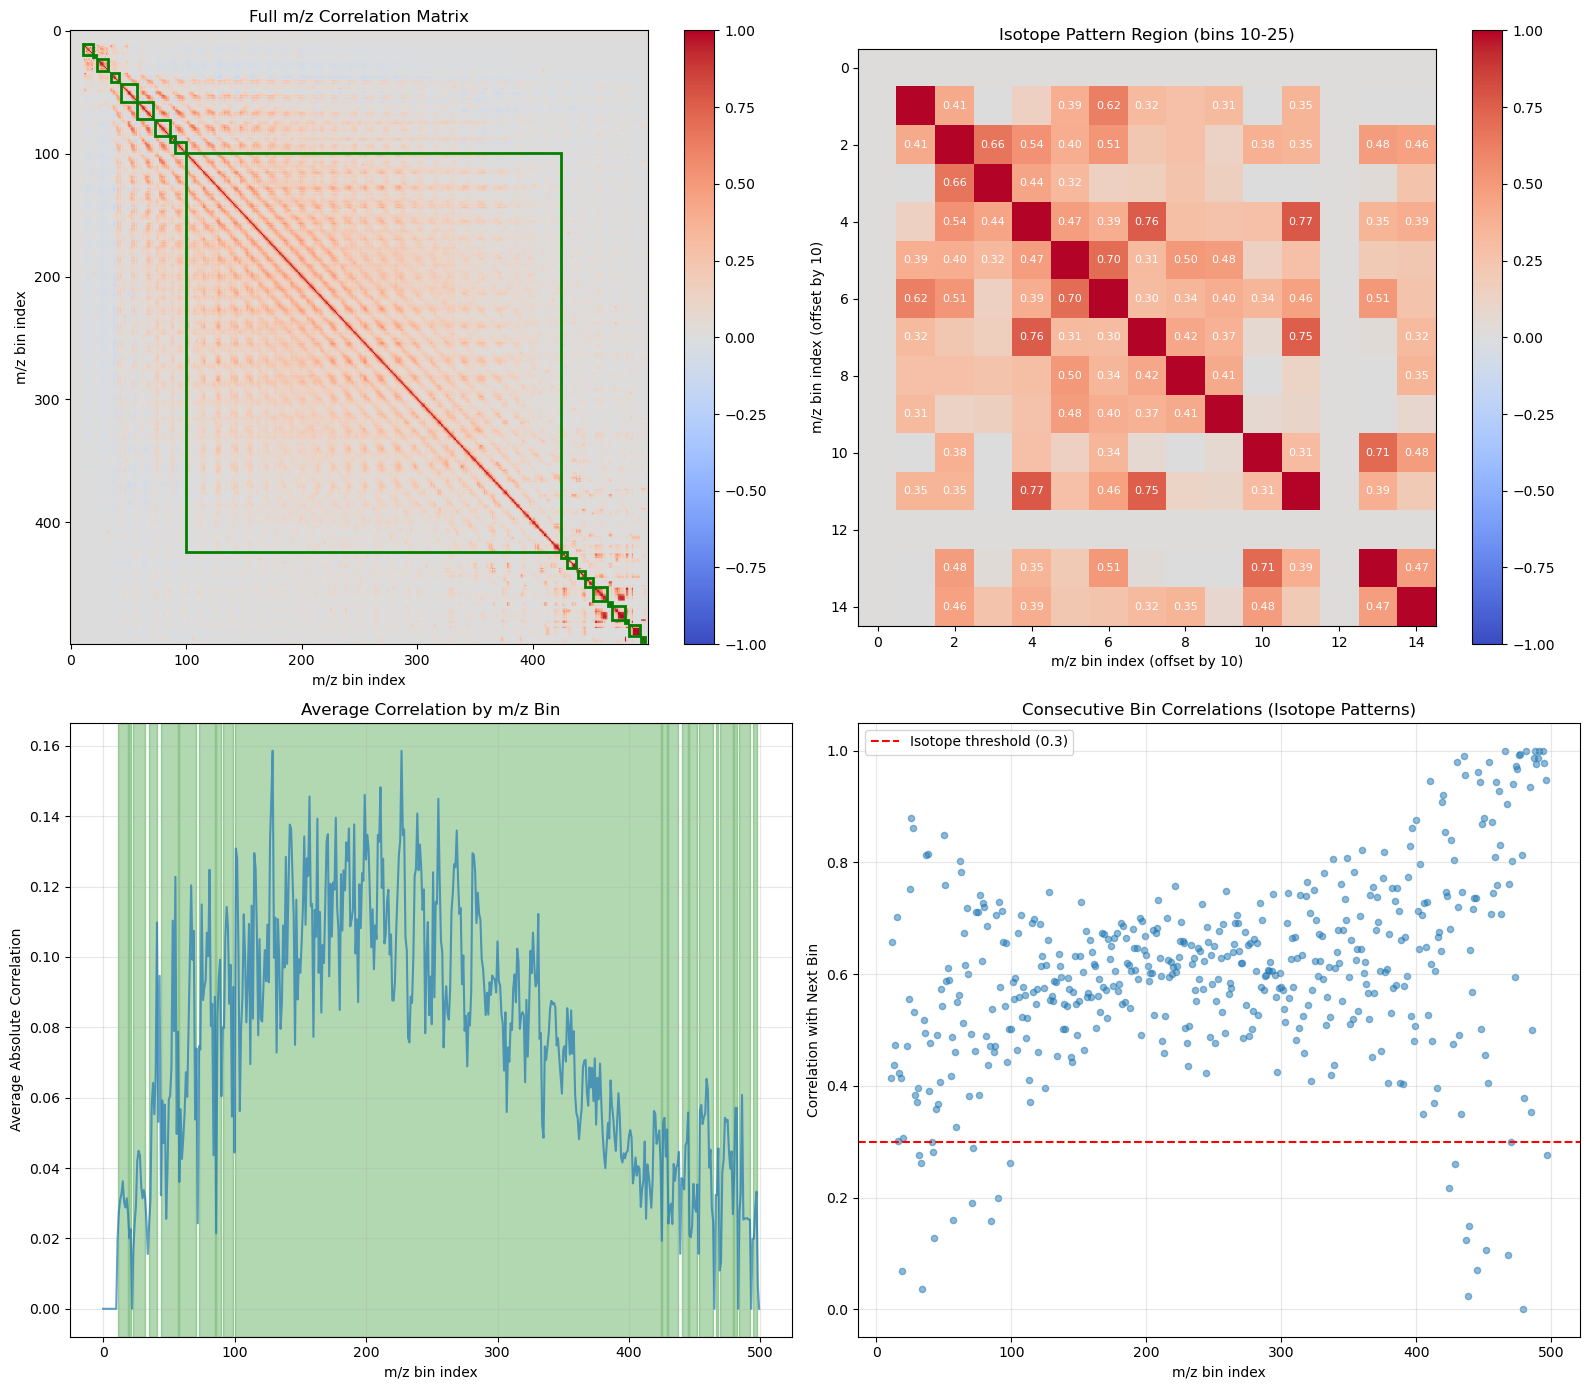


Correlation Statistics:
Mean absolute correlation: 0.0757
Max absolute correlation: 0.1586
Percentage of bins with >0.1 correlation: 29.0%

Strongest isotope patterns (top 10):
  Bins 494-495: correlation = 1.000
  Bins 481-482: correlation = 1.000
  Bins 466-467: correlation = 1.000
  Bins 491-492: correlation = 1.000
  Bins 488-489: correlation = 1.000
  Bins 477-478: correlation = 0.994
  Bins 476-477: correlation = 0.993
  Bins 435-436: correlation = 0.990
  Bins 487-488: correlation = 0.987
  Bins 490-491: correlation = 0.986


In [5]:
# Calculate correlation matrix for m/z values
print("Calculating m/z correlation matrix...")

# Use a subset for correlation calculation to save memory
subset_size = min(5000, len(y_train_transformed))
y_subset = y_train_transformed[:subset_size]

# Remove zero variance columns for correlation analysis
variances = np.var(y_subset, axis=0)
non_zero_var_mask = variances > 0
print(f"Number of zero variance m/z bins: {np.sum(~non_zero_var_mask)}")

# Calculate correlation matrix only for non-zero variance columns
y_subset_filtered = y_subset[:, non_zero_var_mask]
y_df = pd.DataFrame(y_subset_filtered)
corr_matrix_filtered = y_df.corr().values

# Create full correlation matrix with zeros for zero-variance columns
corr_matrix = np.zeros((y_subset.shape[1], y_subset.shape[1]))
non_zero_indices = np.where(non_zero_var_mask)[0]
for i, idx_i in enumerate(non_zero_indices):
    for j, idx_j in enumerate(non_zero_indices):
        corr_matrix[idx_i, idx_j] = corr_matrix_filtered[i, j]

# Replace NaN values with 0 (uncorrelated)
corr_matrix = np.nan_to_num(corr_matrix, nan=0.0)

# Identify isotope patterns (consecutive highly correlated bins)
isotope_patterns = []
for i in range(len(corr_matrix) - 1):
    if i in non_zero_indices and i+1 in non_zero_indices:
        corr_consecutive = abs(corr_matrix[i, i+1])
        if corr_consecutive > CONFIG['chain']['isotope_correlation_threshold']:
            isotope_patterns.append((i, i+1, corr_consecutive))

# Group consecutive isotope patterns
isotope_groups = []
if isotope_patterns:
    current_group = [isotope_patterns[0][0], isotope_patterns[0][1]]
    for i in range(1, len(isotope_patterns)):
        if isotope_patterns[i][0] == current_group[-1]:
            current_group.append(isotope_patterns[i][1])
        else:
            isotope_groups.append(list(set(current_group)))
            current_group = [isotope_patterns[i][0], isotope_patterns[i][1]]
    isotope_groups.append(list(set(current_group)))

print(f"\nIdentified {len(isotope_groups)} isotope pattern groups:")
for group in isotope_groups:
    print(f"  Bins {min(group)}-{max(group)}: {len(group)} connected bins")

# Visualize correlation structure with isotope patterns highlighted
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Full correlation matrix
ax1 = axes[0, 0]
im1 = ax1.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax1.set_title('Full m/z Correlation Matrix')
ax1.set_xlabel('m/z bin index')
ax1.set_ylabel('m/z bin index')
plt.colorbar(im1, ax=ax1)

# Highlight isotope regions
for group in isotope_groups:
    min_idx, max_idx = min(group), max(group)
    rect = plt.Rectangle((min_idx-0.5, min_idx-0.5), max_idx-min_idx+1, max_idx-min_idx+1,
                        fill=False, edgecolor='green', linewidth=2)
    ax1.add_patch(rect)

# 2. Zoom in on isotope region (bins 10-25)
ax2 = axes[0, 1]
im2 = ax2.imshow(corr_matrix[10:25, 10:25], cmap='coolwarm', vmin=-1, vmax=1)
ax2.set_title('Isotope Pattern Region (bins 10-25)')
ax2.set_xlabel('m/z bin index (offset by 10)')
ax2.set_ylabel('m/z bin index (offset by 10)')
plt.colorbar(im2, ax=ax2)

# Add correlation values for strong correlations
for i in range(15):
    for j in range(15):
        if abs(corr_matrix[10+i, 10+j]) > 0.3 and i != j:
            ax2.text(j, i, f'{corr_matrix[10+i, 10+j]:.2f}', 
                    ha='center', va='center', fontsize=8, color='white')

# 3. Average correlation by bin
ax3 = axes[1, 0]
corr_matrix_no_diag = corr_matrix.copy()
np.fill_diagonal(corr_matrix_no_diag, np.nan)
avg_correlation = np.nanmean(np.abs(corr_matrix_no_diag), axis=1)
avg_correlation = np.nan_to_num(avg_correlation, nan=0.0)

ax3.plot(avg_correlation, alpha=0.7)
ax3.set_xlabel('m/z bin index')
ax3.set_ylabel('Average Absolute Correlation')
ax3.set_title('Average Correlation by m/z Bin')
ax3.grid(True, alpha=0.3)

# Highlight isotope regions
for group in isotope_groups:
    ax3.axvspan(min(group), max(group), alpha=0.3, color='green', label='Isotope region')

# 4. Consecutive bin correlations (isotope pattern indicator)
ax4 = axes[1, 1]
consecutive_corrs = [abs(corr_matrix[i, i+1]) for i in range(len(corr_matrix)-1) 
                    if i in non_zero_indices and i+1 in non_zero_indices]
consecutive_indices = [i for i in range(len(corr_matrix)-1) 
                      if i in non_zero_indices and i+1 in non_zero_indices]

ax4.scatter(consecutive_indices, consecutive_corrs, alpha=0.5, s=20)
ax4.axhline(y=CONFIG['chain']['isotope_correlation_threshold'], color='r', 
           linestyle='--', label=f'Isotope threshold ({CONFIG["chain"]["isotope_correlation_threshold"]})')
ax4.set_xlabel('m/z bin index')
ax4.set_ylabel('Correlation with Next Bin')
ax4.set_title('Consecutive Bin Correlations (Isotope Patterns)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("\nCorrelation Statistics:")
print(f"Mean absolute correlation: {np.mean(avg_correlation):.4f}")
print(f"Max absolute correlation: {np.max(avg_correlation):.4f}")
print(f"Percentage of bins with >0.1 correlation: {np.sum(avg_correlation > 0.1) / len(avg_correlation) * 100:.1f}%")
print(f"\nStrongest isotope patterns (top 10):")
sorted_patterns = sorted(isotope_patterns, key=lambda x: x[2], reverse=True)[:10]
for pattern in sorted_patterns:
    print(f"  Bins {pattern[0]}-{pattern[1]}: correlation = {pattern[2]:.3f}")

# Store isotope information in config
CONFIG['detected_isotope_groups'] = isotope_groups
CONFIG['isotope_patterns'] = isotope_patterns

## 6. Define Advanced Chain Ordering Strategies

Create ordering strategies that leverage the detected isotope patterns.

Testing chain ordering strategies...

Default order (first 20): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Random order (first 20): [361  73 374 155 104 394 377 124  68 450   9 194 406  84 371 388 495  30
 316 408]
Correlation order (first 20): [129 227 211 199 157 128 255 239 177 163 191 142 187 143 229 269 171 201
 209 228]
Variance order (first 20): [ 58  91  44  43 105 121 109  86  72  55 135  77  79 145 214  93  57 144
  41  95]
Isotope order (first 20): [11 12 13 14 15 16 17 18 19 20 21 23 24 25 26 27 28 29 30 31]


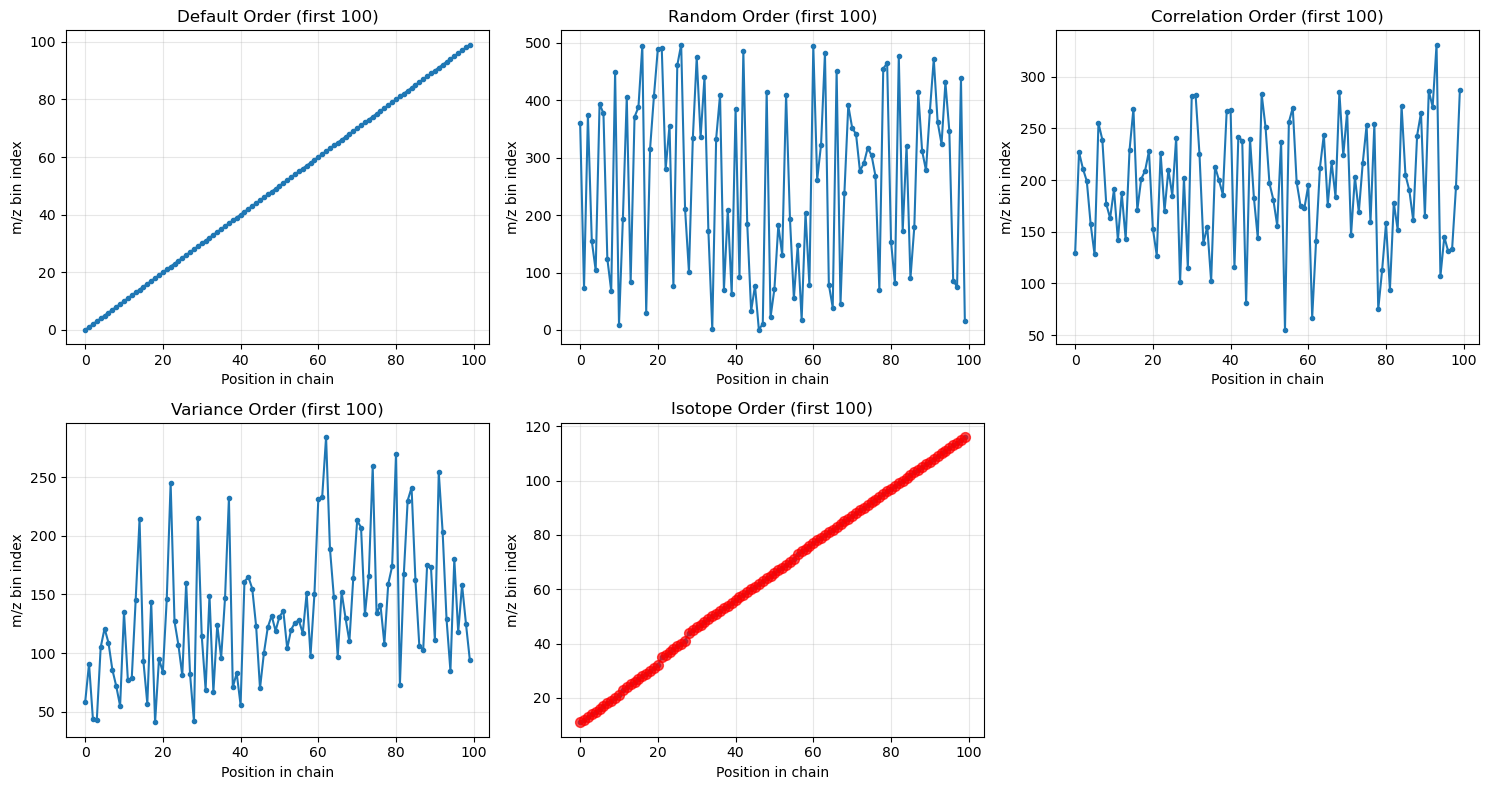


Isotope ordering analysis:
First 30 positions in isotope order: [11 12 13 14 15 16 17 18 19 20 21 23 24 25 26 27 28 29 30 31 32 35 36 37
 38 39 40 41 44 45]

Isotope groups placement:
  Group 0 (bins 11-19): positions 0-8
  Group 1 (bins 20-21): positions 9-10
  Group 2 (bins 23-32): positions 11-20
  Group 3 (bins 35-41): positions 21-27
  Group 4 (bins 44-57): positions 28-41
  Group 5 (bins 58-71): positions 42-55
  Group 6 (bins 73-85): positions 56-68
  Group 7 (bins 86-90): positions 69-73
  Group 8 (bins 91-99): positions 74-82
  Group 9 (bins 100-424): positions 83-407
  Group 10 (bins 425-429): positions 408-412
  Group 11 (bins 430-437): positions 413-420
  Group 12 (bins 440-445): positions 421-426
  Group 13 (bins 446-452): positions 427-433
  Group 14 (bins 453-464): positions 434-445
  Group 15 (bins 466-468): positions 446-448
  Group 16 (bins 469-479): positions 449-459
  Group 17 (bins 480-482): positions 460-462
  Group 18 (bins 484-492): positions 463-471
  Group 19

In [6]:
def get_chain_order(y_train, strategy='default', random_state=None, config=None):
    """Get the order of outputs for RegressorChain.
    
    Parameters:
    -----------
    y_train : array-like, shape (n_samples, n_outputs)
        Training targets
    strategy : str
        Ordering strategy: 'default', 'random', 'correlation', 'variance', 'intensity', 'isotope'
    random_state : int
        Random state for reproducibility
    config : dict
        Configuration dictionary with isotope information
        
    Returns:
    --------
    order : array-like
        Indices specifying the chain order
    """
    n_outputs = y_train.shape[1]
    
    if strategy == 'default':
        # Natural order (low to high m/z)
        order = np.arange(n_outputs)
        
    elif strategy == 'random':
        # Random order
        rng = np.random.RandomState(random_state)
        order = np.arange(n_outputs)
        rng.shuffle(order)
        
    elif strategy == 'correlation':
        # Order by average correlation with other outputs (highest first)
        subset_size = min(5000, len(y_train))
        y_subset = y_train[:subset_size]
        
        # Handle zero variance columns
        variances = np.var(y_subset, axis=0)
        non_zero_var_mask = variances > 0
        
        # Calculate correlations only for non-zero variance columns
        avg_corr = np.zeros(n_outputs)
        
        if np.sum(non_zero_var_mask) > 1:
            y_subset_filtered = y_subset[:, non_zero_var_mask]
            y_df = pd.DataFrame(y_subset_filtered)
            corr_matrix_filtered = y_df.corr().values
            
            np.fill_diagonal(corr_matrix_filtered, np.nan)
            avg_corr_filtered = np.nanmean(np.abs(corr_matrix_filtered), axis=1)
            avg_corr_filtered = np.nan_to_num(avg_corr_filtered, nan=0.0)
            
            non_zero_indices = np.where(non_zero_var_mask)[0]
            for i, idx in enumerate(non_zero_indices):
                avg_corr[idx] = avg_corr_filtered[i]
        
        order = np.argsort(avg_corr)[::-1]
        
    elif strategy == 'variance':
        # Order by variance (highest first)
        variances = np.var(y_train, axis=0)
        order = np.argsort(variances)[::-1]
        
    elif strategy == 'intensity':
        # Order by average intensity (highest first)
        avg_intensity = np.mean(y_train, axis=0)
        order = np.argsort(avg_intensity)[::-1]
        
    elif strategy == 'isotope':
        # Isotope-aware ordering: process isotope groups together
        # Start with the first bin of each isotope group, then add the rest
        if config and 'detected_isotope_groups' in config:
            isotope_groups = config['detected_isotope_groups']
            
            order_list = []
            added = set()
            
            # Process each isotope group
            for group in isotope_groups:
                # Add bins in the group sequentially
                for bin_idx in sorted(group):
                    if bin_idx not in added and bin_idx < n_outputs:
                        order_list.append(bin_idx)
                        added.add(bin_idx)
            
            # Add remaining high-correlation bins
            subset_size = min(5000, len(y_train))
            y_subset = y_train[:subset_size]
            variances = np.var(y_subset, axis=0)
            non_zero_var_mask = variances > 0
            
            if np.sum(non_zero_var_mask) > 1:
                y_subset_filtered = y_subset[:, non_zero_var_mask]
                y_df = pd.DataFrame(y_subset_filtered)
                corr_matrix = y_df.corr().values
                np.fill_diagonal(corr_matrix, np.nan)
                avg_corr = np.nanmean(np.abs(corr_matrix), axis=1)
                avg_corr = np.nan_to_num(avg_corr, nan=0.0)
                
                # Map back to full indices
                full_avg_corr = np.zeros(n_outputs)
                non_zero_indices = np.where(non_zero_var_mask)[0]
                for i, idx in enumerate(non_zero_indices):
                    full_avg_corr[idx] = avg_corr[i]
                
                # Add high correlation bins not in isotope groups
                high_corr_bins = np.where(full_avg_corr > config['chain']['correlation_threshold'])[0]
                for bin_idx in high_corr_bins:
                    if bin_idx not in added:
                        order_list.append(bin_idx)
                        added.add(bin_idx)
            
            # Add remaining bins by variance
            remaining_bins = [i for i in range(n_outputs) if i not in added]
            remaining_bins_sorted = sorted(remaining_bins, key=lambda x: variances[x], reverse=True)
            order_list.extend(remaining_bins_sorted)
            
            order = np.array(order_list)
        else:
            # Fallback to correlation ordering
            return get_chain_order(y_train, 'correlation', random_state)
            
    else:
        raise ValueError(f"Unknown strategy: {strategy}")
        
    return order

# Test different ordering strategies
print("Testing chain ordering strategies...\n")

strategies = ['default', 'random', 'correlation', 'variance', 'isotope']
for strategy in strategies:
    order = get_chain_order(y_train_transformed, strategy, random_state=SEED, config=CONFIG)
    print(f"{strategy.capitalize()} order (first 20): {order[:20]}")
    
# Visualize ordering strategies
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, strategy in enumerate(strategies + ['']):
    if i < len(strategies):
        order = get_chain_order(y_train_transformed, strategy, random_state=SEED, config=CONFIG)
        axes[i].plot(order[:100], 'o-', markersize=3)
        axes[i].set_title(f'{strategy.capitalize()} Order (first 100)')
        axes[i].set_xlabel('Position in chain')
        axes[i].set_ylabel('m/z bin index')
        axes[i].grid(True, alpha=0.3)
        
        # Highlight isotope regions in the isotope strategy
        if strategy == 'isotope' and 'detected_isotope_groups' in CONFIG:
            for j, group in enumerate(CONFIG['detected_isotope_groups']):
                group_positions = [np.where(order == bin_idx)[0][0] for bin_idx in group if bin_idx in order[:100]]
                if group_positions:
                    axes[i].scatter(group_positions, [order[p] for p in group_positions], 
                                  color='red', s=50, alpha=0.7, zorder=5)
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# Analyze isotope ordering effectiveness
isotope_order = get_chain_order(y_train_transformed, 'isotope', random_state=SEED, config=CONFIG)
print("\nIsotope ordering analysis:")
print(f"First 30 positions in isotope order: {isotope_order[:30]}")
print("\nIsotope groups placement:")
for i, group in enumerate(CONFIG['detected_isotope_groups']):
    positions = [np.where(isotope_order == bin_idx)[0][0] for bin_idx in group]
    print(f"  Group {i} (bins {min(group)}-{max(group)}): positions {min(positions)}-{max(positions)}")

## 7. Implement Hybrid Model

Create a hybrid approach that uses RegressorChain for correlated regions and MultiOutput for others.


Creating Hybrid Model...
Hybrid model configuration:
  Chain bins (RegressorChain): 476
  Multi bins (MultiOutput): 24


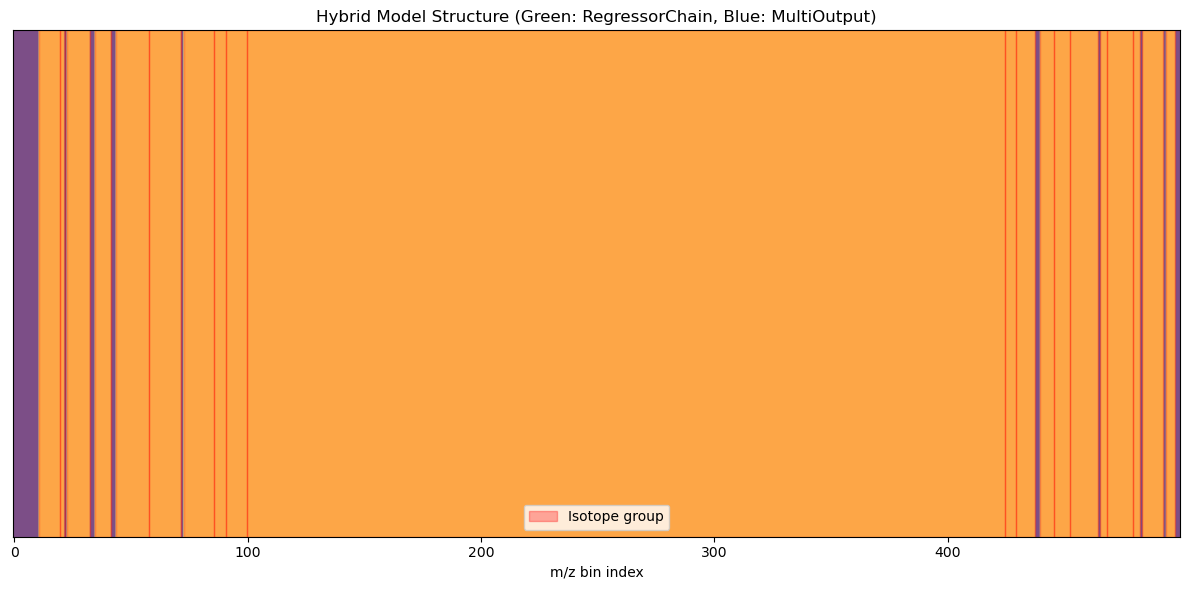

In [7]:
class HybridMassSpecPredictor:
    """Hybrid model using RegressorChain for correlated regions and MultiOutput for others."""
    
    def __init__(self, base_estimator, isotope_groups, correlation_threshold=0.2, 
                 corr_matrix=None, random_state=None):
        self.base_estimator = base_estimator
        self.isotope_groups = isotope_groups
        self.correlation_threshold = correlation_threshold
        self.corr_matrix = corr_matrix
        self.random_state = random_state
        
        # Determine which bins to chain
        self.chain_bins = set()
        self.multi_bins = set()
        
        # Add isotope groups to chain bins
        for group in isotope_groups:
            self.chain_bins.update(group)
        
        # Add high correlation bins if correlation matrix provided
        if corr_matrix is not None:
            n_bins = corr_matrix.shape[0]
            corr_matrix_no_diag = corr_matrix.copy()
            np.fill_diagonal(corr_matrix_no_diag, np.nan)
            avg_corr = np.nanmean(np.abs(corr_matrix_no_diag), axis=1)
            avg_corr = np.nan_to_num(avg_corr, nan=0.0)
            
            high_corr_bins = np.where(avg_corr > correlation_threshold)[0]
            self.chain_bins.update(high_corr_bins)
            
            # All other bins use MultiOutput
            self.multi_bins = set(range(n_bins)) - self.chain_bins
        
        self.chain_bins = sorted(list(self.chain_bins))
        self.multi_bins = sorted(list(self.multi_bins))
        
        print(f"Hybrid model configuration:")
        print(f"  Chain bins (RegressorChain): {len(self.chain_bins)}")
        print(f"  Multi bins (MultiOutput): {len(self.multi_bins)}")
        
    def fit(self, X, y):
        """Fit the hybrid model."""
        from sklearn.base import clone
        
        # Fit RegressorChain for correlated bins
        if self.chain_bins:
            y_chain = y[:, self.chain_bins]
            
            # Create order for chain (isotope groups first)
            chain_order = []
            added = set()
            
            # Add isotope groups in order
            for group in self.isotope_groups:
                group_in_chain = [b for b in group if b in self.chain_bins]
                for bin_idx in sorted(group_in_chain):
                    if bin_idx in self.chain_bins:
                        chain_idx = self.chain_bins.index(bin_idx)
                        if chain_idx not in added:
                            chain_order.append(chain_idx)
                            added.add(chain_idx)
            
            # Add remaining chain bins
            for i in range(len(self.chain_bins)):
                if i not in added:
                    chain_order.append(i)
            
            self.chain_model = RegressorChain(
                base_estimator=clone(self.base_estimator),
                order=chain_order,
                random_state=self.random_state
            )
            print("\nFitting RegressorChain for correlated bins...")
            self.chain_model.fit(X, y_chain)
        
        # Fit MultiOutputRegressor for independent bins
        if self.multi_bins:
            y_multi = y[:, self.multi_bins]
            self.multi_model = MultiOutputRegressor(
                estimator=clone(self.base_estimator),
                n_jobs=-1
            )
            print("Fitting MultiOutputRegressor for independent bins...")
            self.multi_model.fit(X, y_multi)
        
        return self
    
    def predict(self, X):
        """Predict using the hybrid model."""
        n_samples = X.shape[0]
        n_outputs = len(self.chain_bins) + len(self.multi_bins)
        
        # Initialize predictions
        y_pred = np.zeros((n_samples, n_outputs))
        
        # Predict with RegressorChain
        if self.chain_bins:
            y_chain_pred = self.chain_model.predict(X)
            y_pred[:, self.chain_bins] = y_chain_pred
        
        # Predict with MultiOutput
        if self.multi_bins:
            y_multi_pred = self.multi_model.predict(X)
            y_pred[:, self.multi_bins] = y_multi_pred
        
        return y_pred

# Create hybrid model
print("\nCreating Hybrid Model...")
base_rf_hybrid = RandomForestRegressor(**CONFIG['rf_base'])

# Use the correlation matrix from earlier
hybrid_model = HybridMassSpecPredictor(
    base_estimator=base_rf_hybrid,
    isotope_groups=CONFIG['detected_isotope_groups'],
    correlation_threshold=CONFIG['chain']['correlation_threshold'],
    corr_matrix=corr_matrix,
    random_state=CONFIG['chain']['random_state']
)

# Visualize hybrid model structure
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Create a color map for bins
bin_colors = np.zeros(CONFIG['data']['mz_bins'])
bin_colors[hybrid_model.chain_bins] = 1  # Chain bins
bin_colors[hybrid_model.multi_bins] = 0.5  # Multi bins

# Plot bins with colors
im = ax.imshow(bin_colors.reshape(1, -1), aspect='auto', cmap='viridis', alpha=0.7)
ax.set_xlabel('m/z bin index')
ax.set_yticks([])
ax.set_title('Hybrid Model Structure (Green: RegressorChain, Blue: MultiOutput)')

# Highlight isotope groups
for group in CONFIG['detected_isotope_groups']:
    ax.axvspan(min(group)-0.5, max(group)+0.5, alpha=0.3, color='red', 
              label='Isotope group' if group == CONFIG['detected_isotope_groups'][0] else '')

ax.legend()
plt.tight_layout()
plt.show()

## 8. Train and Compare Models with Standard Visualizations

Train all models including the hybrid approach and display standard visualizations after each.

TRAINING MULTIOUTPUTREGRESSOR (BASELINE)

MultiOutputRegressor Performance:
  Cosine Similarity: 0.7662
  MSE: 0.0046, R²: 0.2192
  Peak Detection - Precision: 0.4934, Recall: 0.9907, F1: 0.6588

------------------------------------------------------------
GENERATING STANDARD VISUALIZATIONS FOR MULTIOUTPUT
------------------------------------------------------------

1. Standard 2x2 Diagnostic Plots


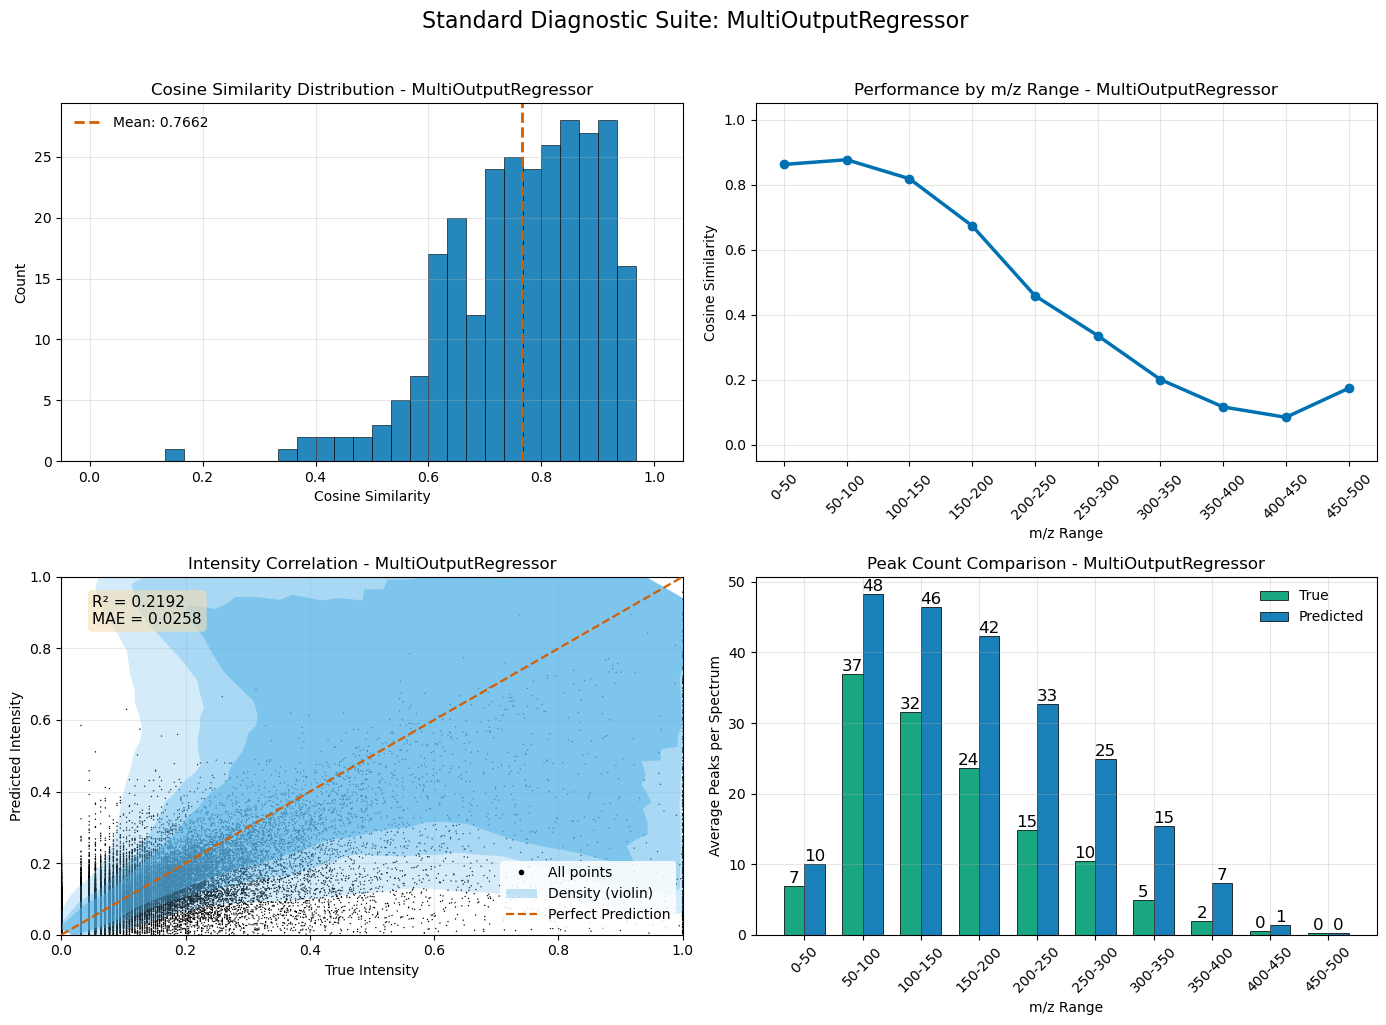


2. Random Spectrum Examples (2x2 Grid)

Selected random examples:
  1. Index 30: Cosine=0.7331, WDP=0.3783
  2. Index 116: Cosine=0.7628, WDP=0.3747
  3. Index 79: Cosine=0.9533, WDP=0.7723
  4. Index 127: Cosine=0.8277, WDP=0.4779


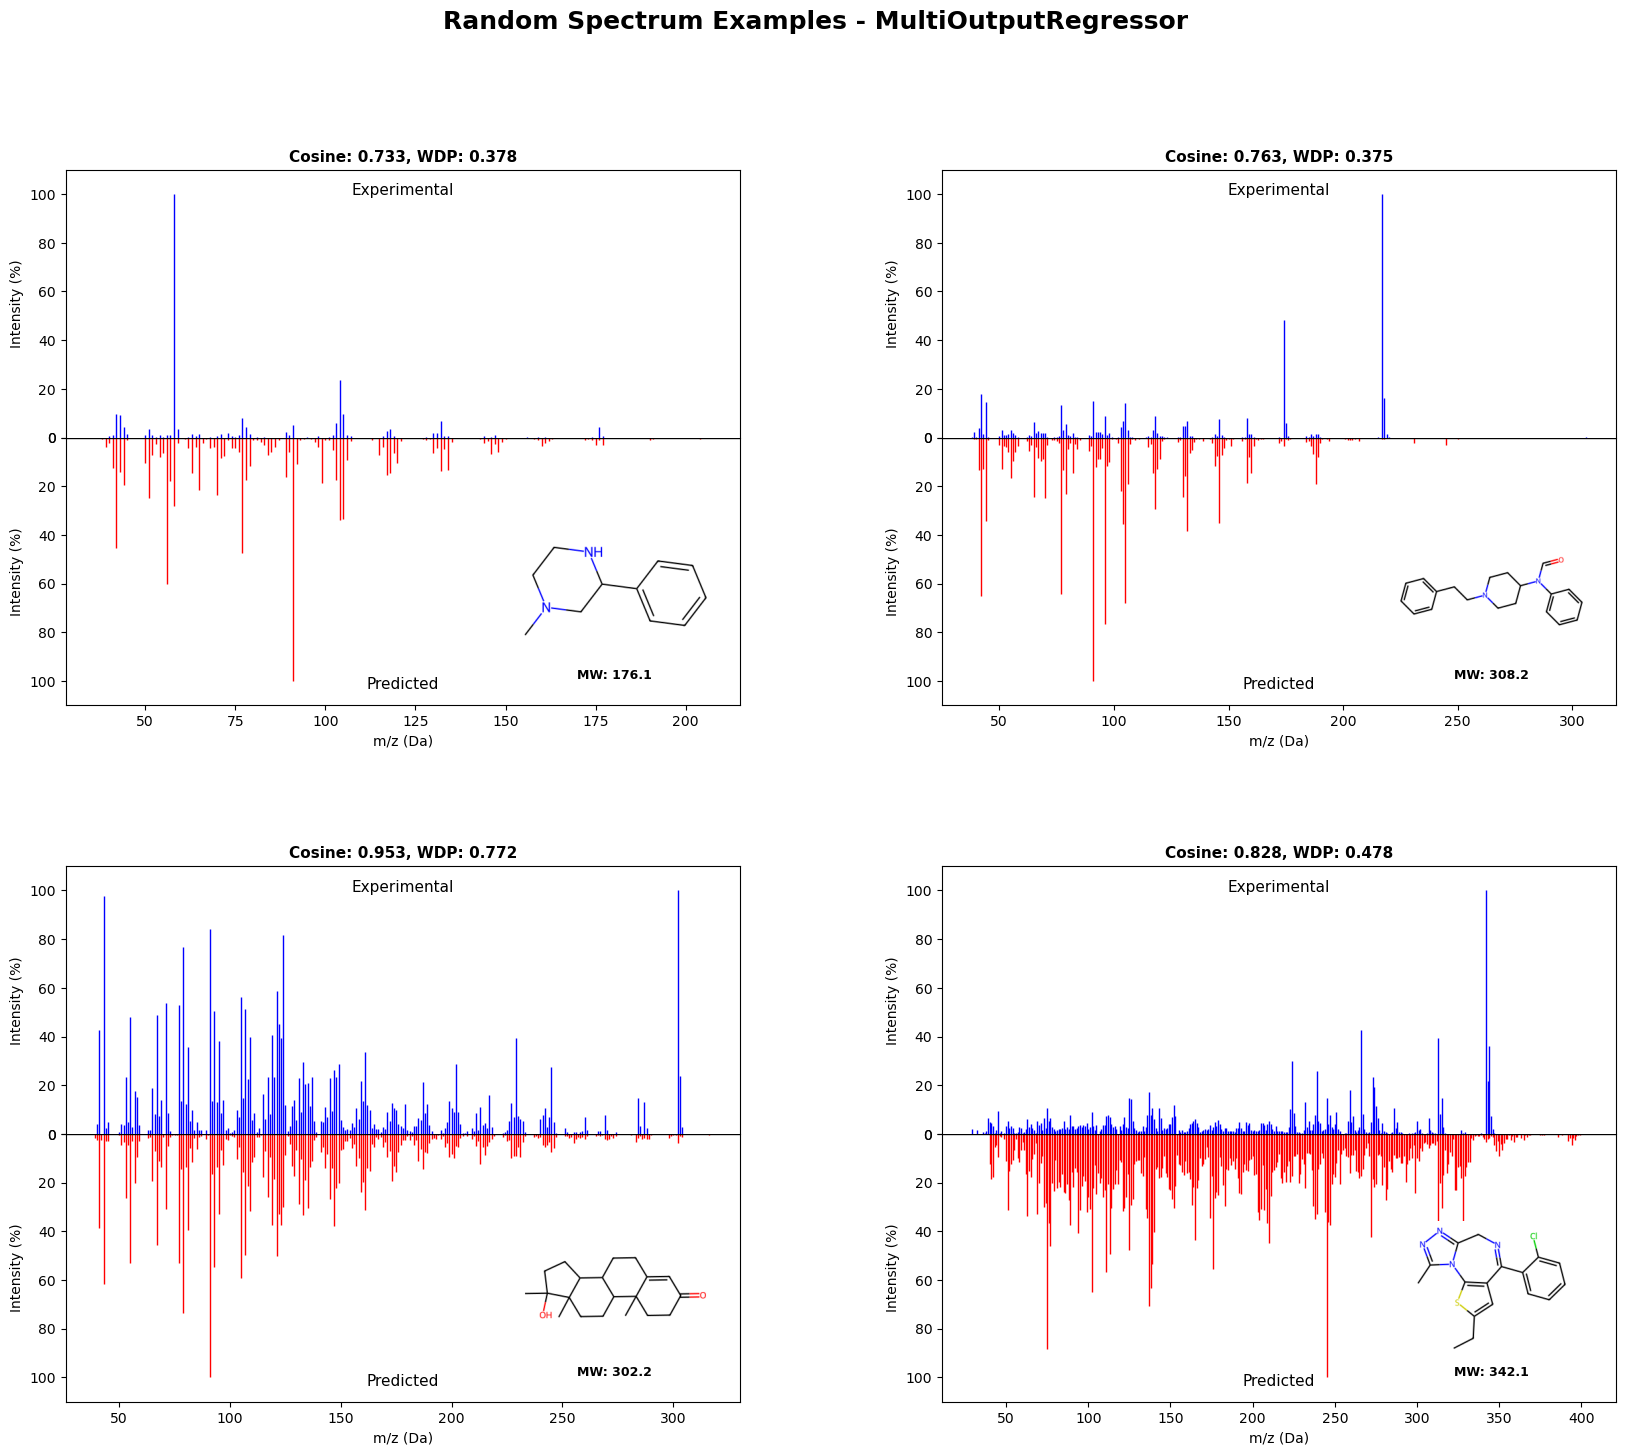


TRAINING REGRESSORCHAIN (ISOTOPE ORDER)

RegressorChain (isotope) Performance:
  Cosine Similarity: 0.7552
  MSE: 0.0049, R²: 0.1695
  Peak Detection - Precision: 0.5027, Recall: 0.9887, F1: 0.6665

------------------------------------------------------------
GENERATING STANDARD VISUALIZATIONS FOR REGRESSORCHAIN
------------------------------------------------------------

1. Standard 2x2 Diagnostic Plots


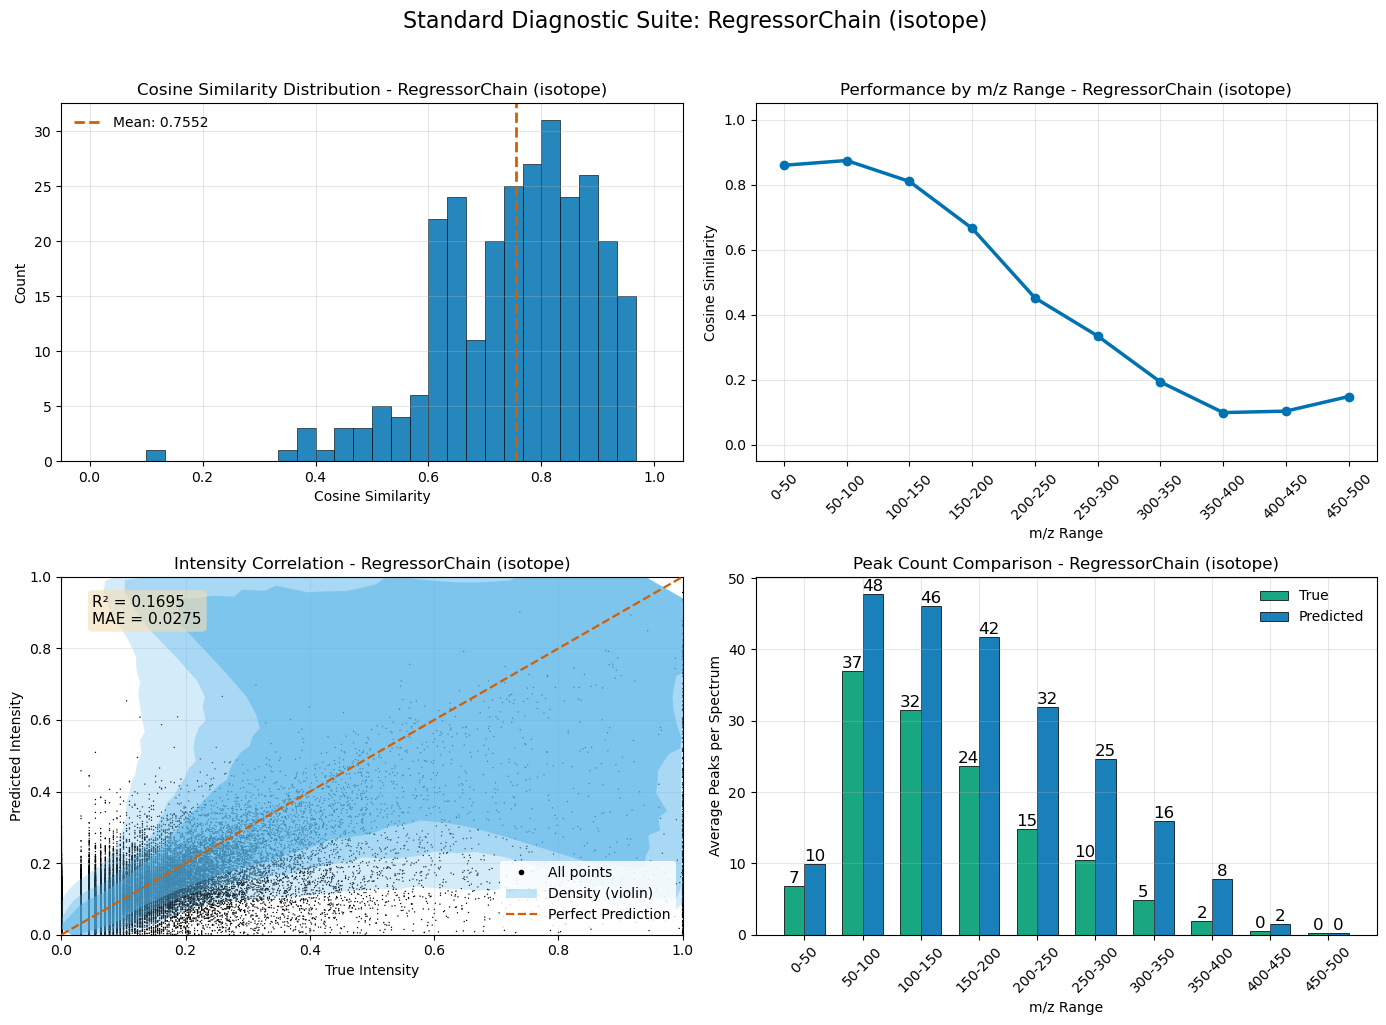


2. Random Spectrum Examples (2x2 Grid)

Selected random examples:
  1. Index 83: Cosine=0.7901, WDP=0.4694
  2. Index 81: Cosine=0.3808, WDP=0.2540
  3. Index 265: Cosine=0.6184, WDP=0.2624
  4. Index 128: Cosine=0.5947, WDP=0.2448


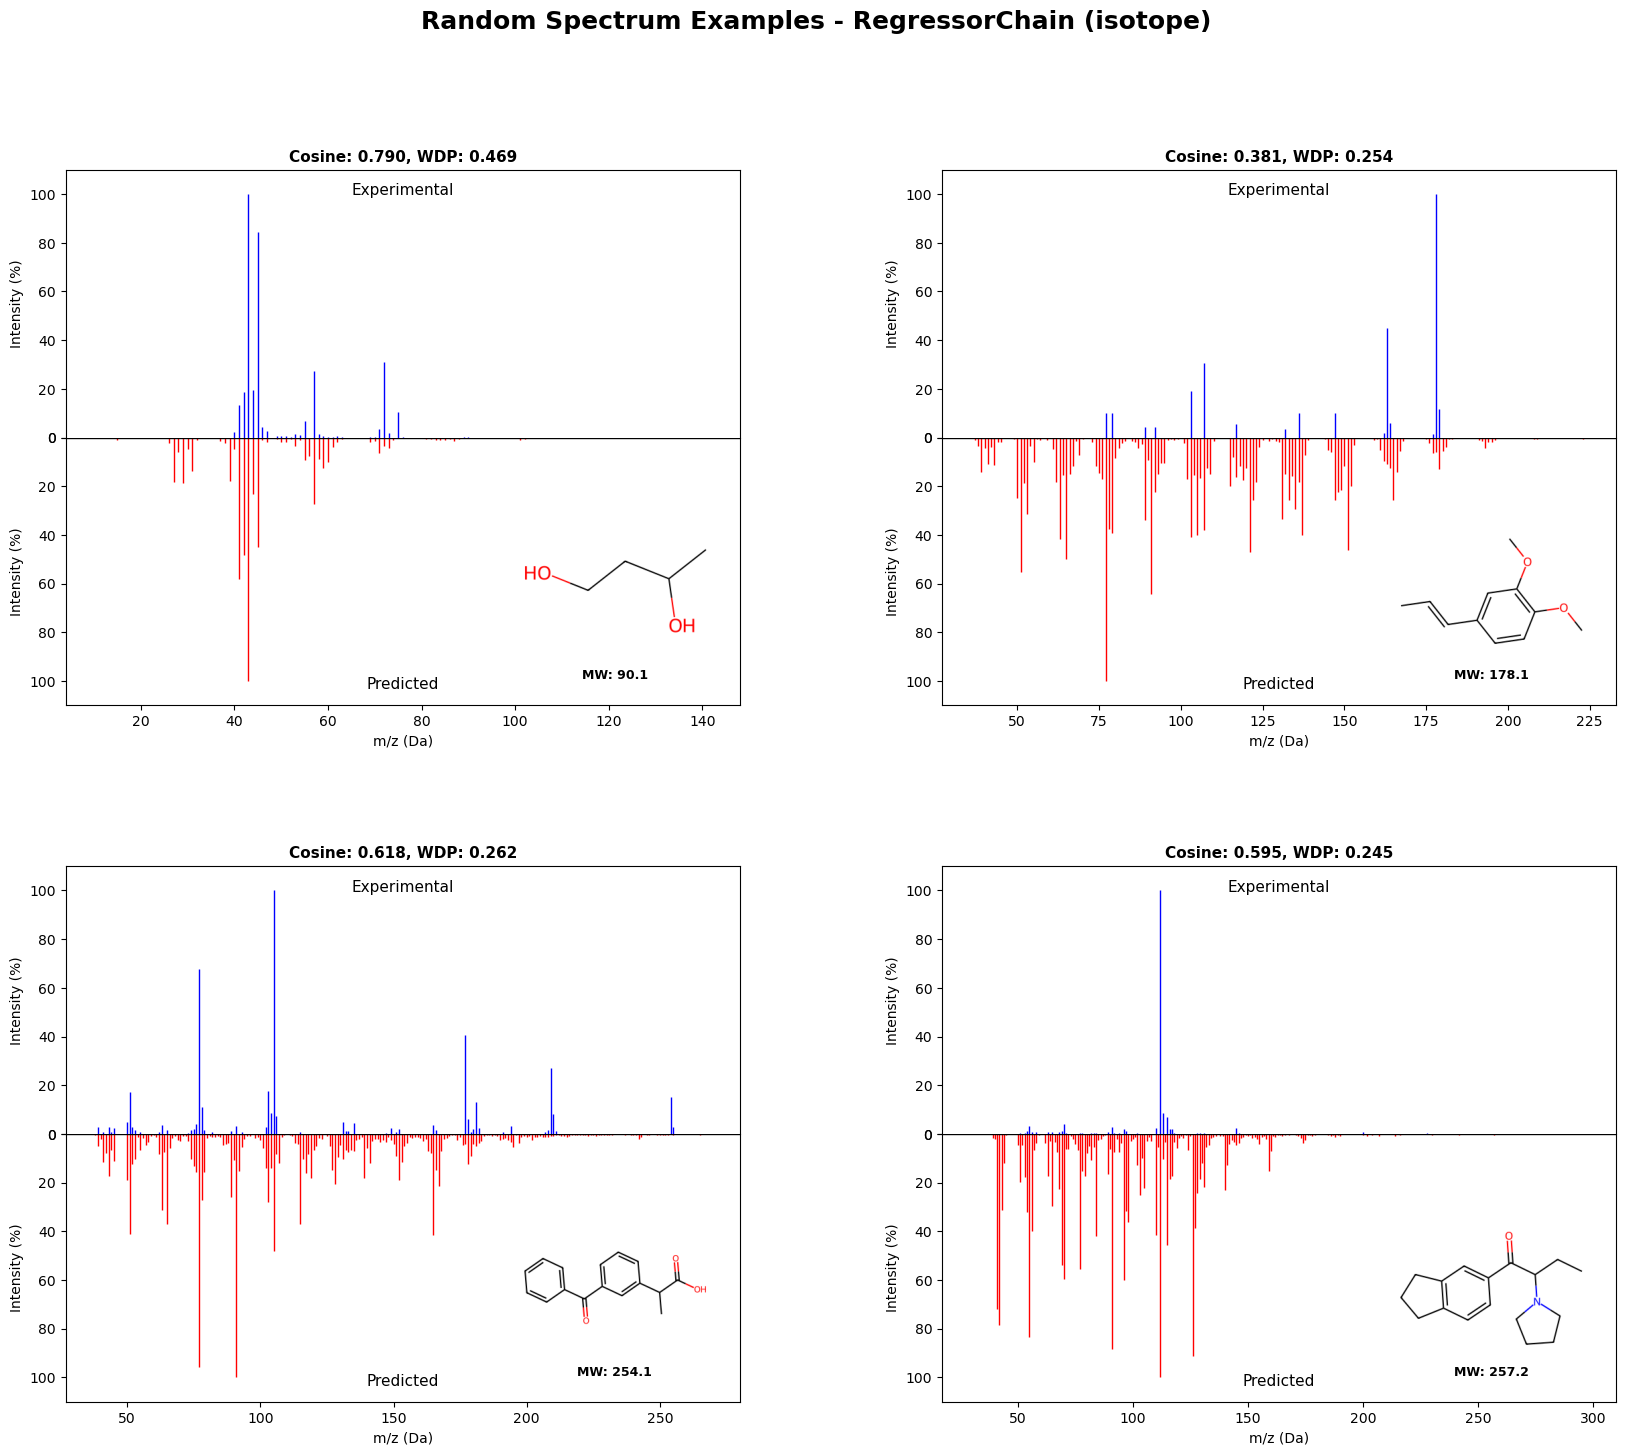


TRAINING HYBRID MODEL

Fitting RegressorChain for correlated bins...
Fitting MultiOutputRegressor for independent bins...

Hybrid Model Performance:
  Cosine Similarity: 0.7557
  MSE: 0.0049, R²: 0.1698
  Peak Detection - Precision: 0.5027, Recall: 0.9887, F1: 0.6665

------------------------------------------------------------
GENERATING STANDARD VISUALIZATIONS FOR HYBRID MODEL
------------------------------------------------------------

1. Standard 2x2 Diagnostic Plots


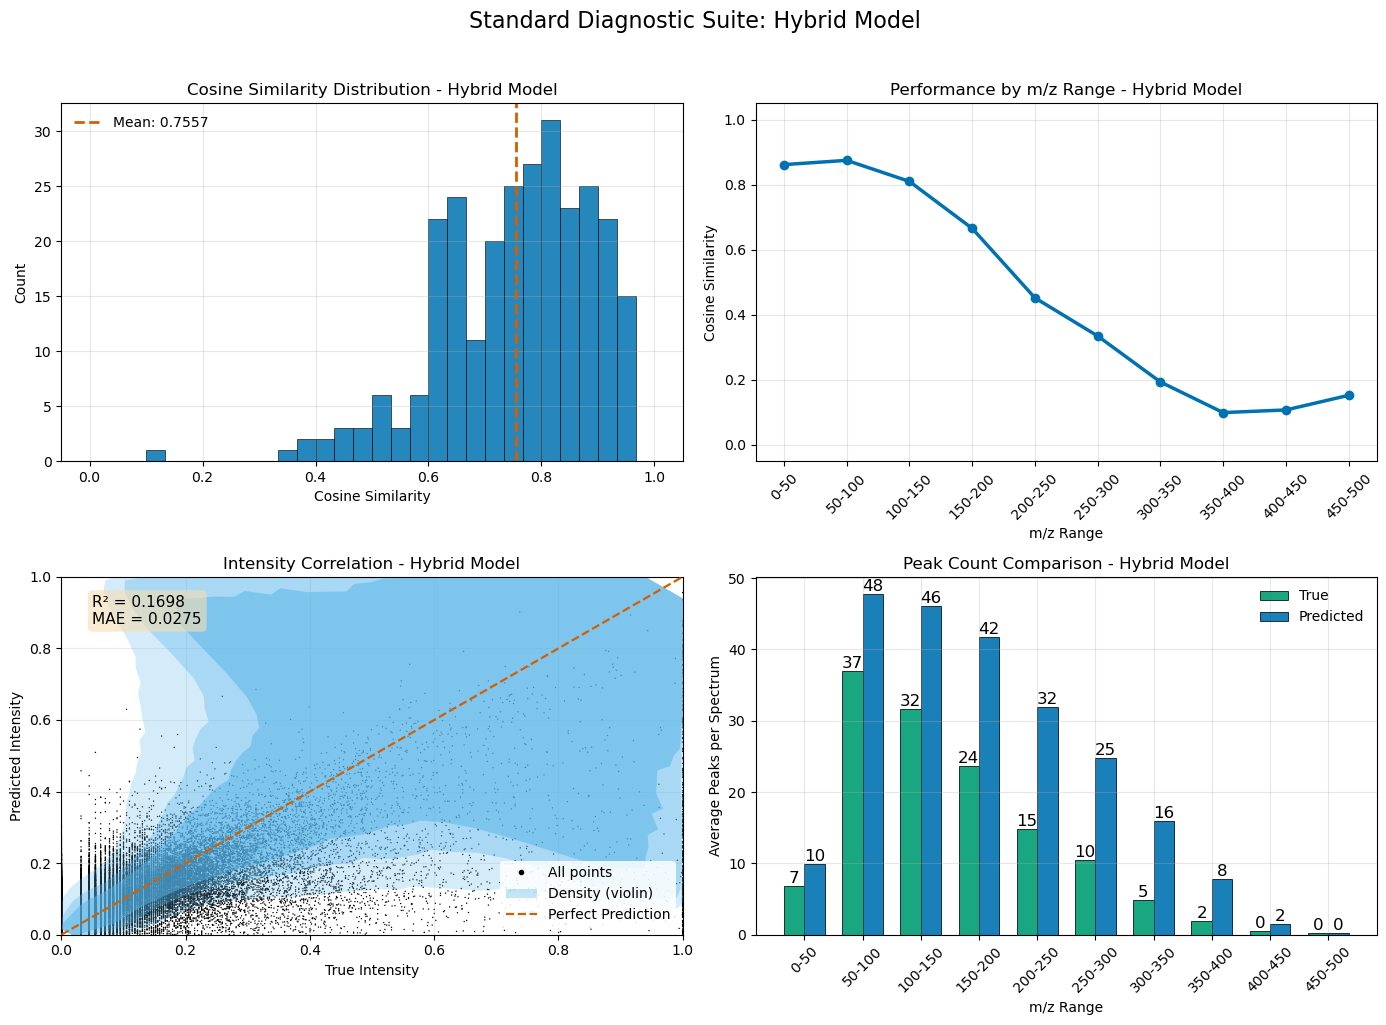


2. Random Spectrum Examples (2x2 Grid)

Selected random examples:
  1. Index 80: Cosine=0.7964, WDP=0.4338
  2. Index 129: Cosine=0.7928, WDP=0.5696
  3. Index 208: Cosine=0.8530, WDP=0.6568
  4. Index 241: Cosine=0.5223, WDP=0.2685


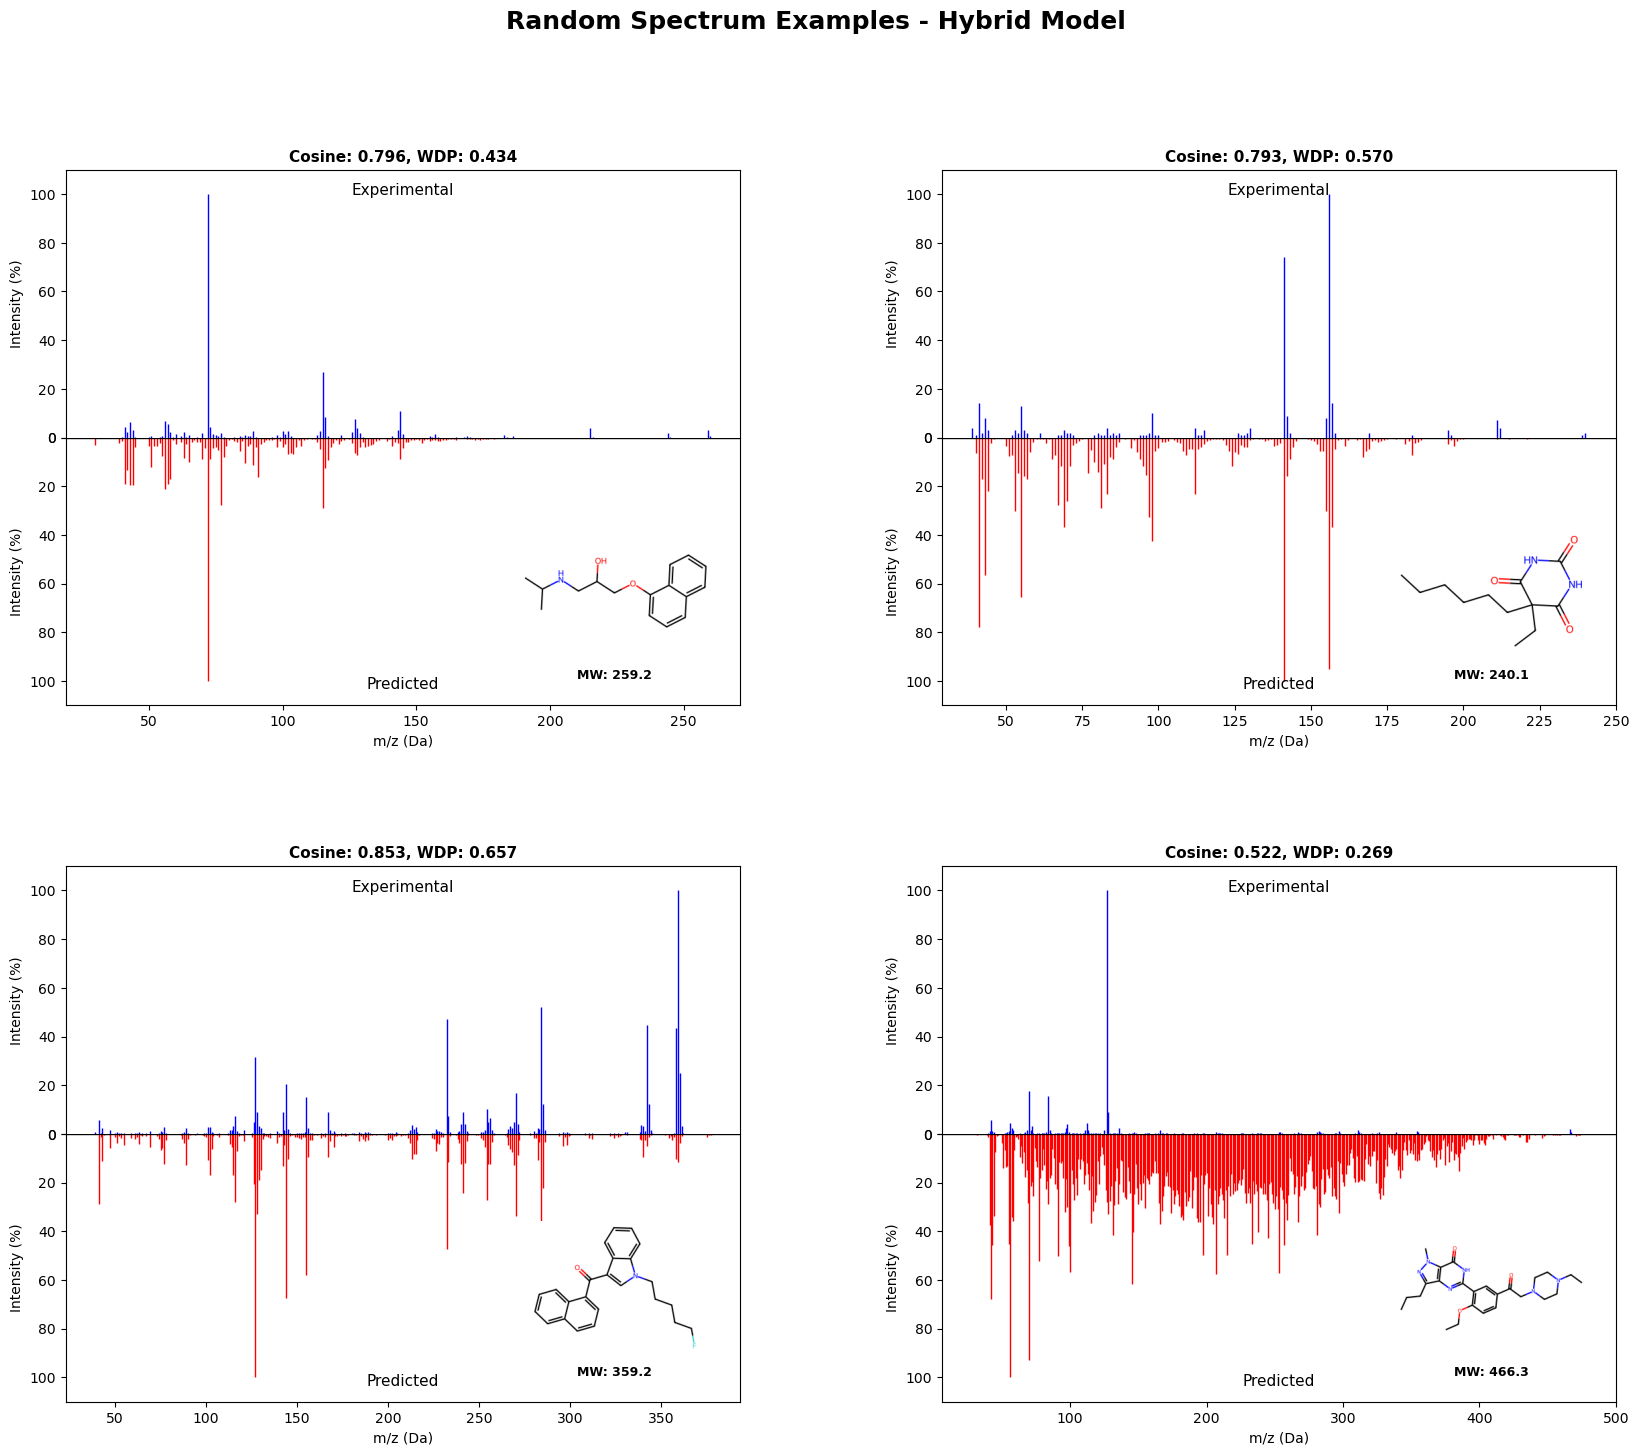

In [8]:
def evaluate_model(y_true, y_pred, tree_predictions, config, model_name="Model"):
    """Comprehensive model evaluation with uncertainties."""
    # Ensure non-negative
    y_pred = np.maximum(y_pred, 0)
    
    # Calculate all metrics
    cosine_mean, cosine_all = cosine_similarity_matrix(y_true, y_pred)
    peak_metrics = peak_detection_metrics(
        y_true, y_pred, config['evaluation']['peak_threshold']
    )
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Regional analysis
    mz_range_sims = cosine_similarity_by_mz_range(y_true, y_pred, config)
    
    results = {
        'cosine': cosine_mean,
        'cosine_similarity': cosine_mean,
        'individual_cos_sims': cosine_all,
        'peak_metrics': peak_metrics,
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mz_range_sims': mz_range_sims,
        'y_true': y_true,
        'y_pred': y_pred
    }
    
    # Print summary
    print(f"\n{model_name} Performance:")
    print(f"  Cosine Similarity: {cosine_mean:.4f}")
    print(f"  MSE: {mse:.4f}, R²: {r2:.4f}")
    print(f"  Peak Detection - Precision: {peak_metrics['precision']:.4f}, "
          f"Recall: {peak_metrics['recall']:.4f}, F1: {peak_metrics['f1_score']:.4f}")
    
    return results

# Dictionary to store results
results_dict = {}

# ============================================================================
# 1. Train baseline MultiOutputRegressor
# ============================================================================
print("=" * 80)
print("TRAINING MULTIOUTPUTREGRESSOR (BASELINE)")
print("=" * 80)

base_rf = RandomForestRegressor(**CONFIG['rf_base'])
multi_output_model = MultiOutputRegressor(
    base_rf,
    n_jobs=-1
)

start_time = time.time()
multi_output_model.fit(X_train_scaled, y_train_transformed)
mo_training_time = time.time() - start_time

y_pred_mo = multi_output_model.predict(X_test_scaled)
y_pred_mo = np.maximum(y_pred_mo, 0)

# Get tree predictions for uncertainty (if available)
tree_predictions_mo = None

results_dict['MultiOutput'] = evaluate_model(
    y_test_transformed, y_pred_mo, tree_predictions_mo, 
    CONFIG, "MultiOutputRegressor"
)
results_dict['MultiOutput']['training_time'] = mo_training_time

# Generate standard visualizations for MultiOutput
print("\n" + "-"*60)
print("GENERATING STANDARD VISUALIZATIONS FOR MULTIOUTPUT")
print("-"*60)

print("\n1. Standard 2x2 Diagnostic Plots")
plot_standard_2x2_diagnostic(results_dict['MultiOutput'], "MultiOutputRegressor", show_uncertainties=False)

print("\n2. Random Spectrum Examples (2x2 Grid)")
plot_random_spectrum_grid(results_dict['MultiOutput'], test_smiles, n_examples=4, model_name="MultiOutputRegressor")

# ============================================================================
# 2. Train RegressorChain with isotope ordering
# ============================================================================
print("\n" + "=" * 80)
print("TRAINING REGRESSORCHAIN (ISOTOPE ORDER)")
print("=" * 80)

chain_order = get_chain_order(y_train_transformed, 'isotope', random_state=SEED, config=CONFIG)
base_rf_chain = RandomForestRegressor(**CONFIG['rf_base'])
chain_model = RegressorChain(
    base_estimator=base_rf_chain,
    order=chain_order,
    random_state=CONFIG['chain']['random_state']
)

start_time = time.time()
chain_model.fit(X_train_scaled, y_train_transformed)
chain_training_time = time.time() - start_time

y_pred_chain = chain_model.predict(X_test_scaled)
y_pred_chain = np.maximum(y_pred_chain, 0)

# Get tree predictions for uncertainty (not easily available for RegressorChain)
tree_predictions_chain = None

results_dict['Chain_isotope'] = evaluate_model(
    y_test_transformed, y_pred_chain, tree_predictions_chain,
    CONFIG, "RegressorChain (isotope)"
)
results_dict['Chain_isotope']['training_time'] = chain_training_time
results_dict['Chain_isotope']['model'] = chain_model

# Generate standard visualizations for RegressorChain
print("\n" + "-"*60)
print("GENERATING STANDARD VISUALIZATIONS FOR REGRESSORCHAIN")
print("-"*60)

print("\n1. Standard 2x2 Diagnostic Plots")
plot_standard_2x2_diagnostic(results_dict['Chain_isotope'], "RegressorChain (isotope)", show_uncertainties=False)

print("\n2. Random Spectrum Examples (2x2 Grid)")
plot_random_spectrum_grid(results_dict['Chain_isotope'], test_smiles, n_examples=4, model_name="RegressorChain (isotope)")

# ============================================================================
# 3. Train Hybrid Model
# ============================================================================
print("\n" + "=" * 80)
print("TRAINING HYBRID MODEL")
print("=" * 80)

start_time = time.time()
hybrid_model.fit(X_train_scaled, y_train_transformed)
hybrid_training_time = time.time() - start_time

y_pred_hybrid = hybrid_model.predict(X_test_scaled)
y_pred_hybrid = np.maximum(y_pred_hybrid, 0)

tree_predictions_hybrid = None

results_dict['Hybrid'] = evaluate_model(
    y_test_transformed, y_pred_hybrid, tree_predictions_hybrid,
    CONFIG, "Hybrid Model"
)
results_dict['Hybrid']['training_time'] = hybrid_training_time
results_dict['Hybrid']['model'] = hybrid_model

# Generate standard visualizations for Hybrid
print("\n" + "-"*60)
print("GENERATING STANDARD VISUALIZATIONS FOR HYBRID MODEL")
print("-"*60)

print("\n1. Standard 2x2 Diagnostic Plots")
plot_standard_2x2_diagnostic(results_dict['Hybrid'], "Hybrid Model", show_uncertainties=False)

print("\n2. Random Spectrum Examples (2x2 Grid)")
plot_random_spectrum_grid(results_dict['Hybrid'], test_smiles, n_examples=4, model_name="Hybrid Model")

# Store predictions for analysis
results_dict['MultiOutput']['predictions'] = y_pred_mo
results_dict['Chain_isotope']['predictions'] = y_pred_chain
results_dict['Hybrid']['predictions'] = y_pred_hybrid

## 9. Analyze Performance on Isotope Regions

Focus analysis on the identified isotope regions where we expect the chain to excel.


ISOTOPE REGION PERFORMANCE ANALYSIS

Group_0_bins_11-19:
  MultiOutput:
    R² = -0.3417
    MSE = 0.0000
    Correlation preservation = nan
  Chain_isotope:
    R² = -0.4127
    MSE = 0.0000
    Correlation preservation = nan
  Hybrid:
    R² = -0.4127
    MSE = 0.0000
    Correlation preservation = nan

Group_1_bins_20-21:
  MultiOutput:
    R² = 0.0000
    MSE = 0.0000
    Correlation preservation = 0.0000
  Chain_isotope:
    R² = 0.0000
    MSE = 0.0000
    Correlation preservation = 0.0000
  Hybrid:
    R² = 0.0000
    MSE = 0.0000
    Correlation preservation = 0.0000

Group_2_bins_23-32:
  MultiOutput:
    R² = -0.3061
    MSE = 0.0010
    Correlation preservation = nan
  Chain_isotope:
    R² = -0.3404
    MSE = 0.0010
    Correlation preservation = nan
  Hybrid:
    R² = -0.3404
    MSE = 0.0010
    Correlation preservation = nan

Group_3_bins_35-41:
  MultiOutput:
    R² = 0.1679
    MSE = 0.0036
    Correlation preservation = 0.8977
  Chain_isotope:
    R² = 0.1547
    MSE

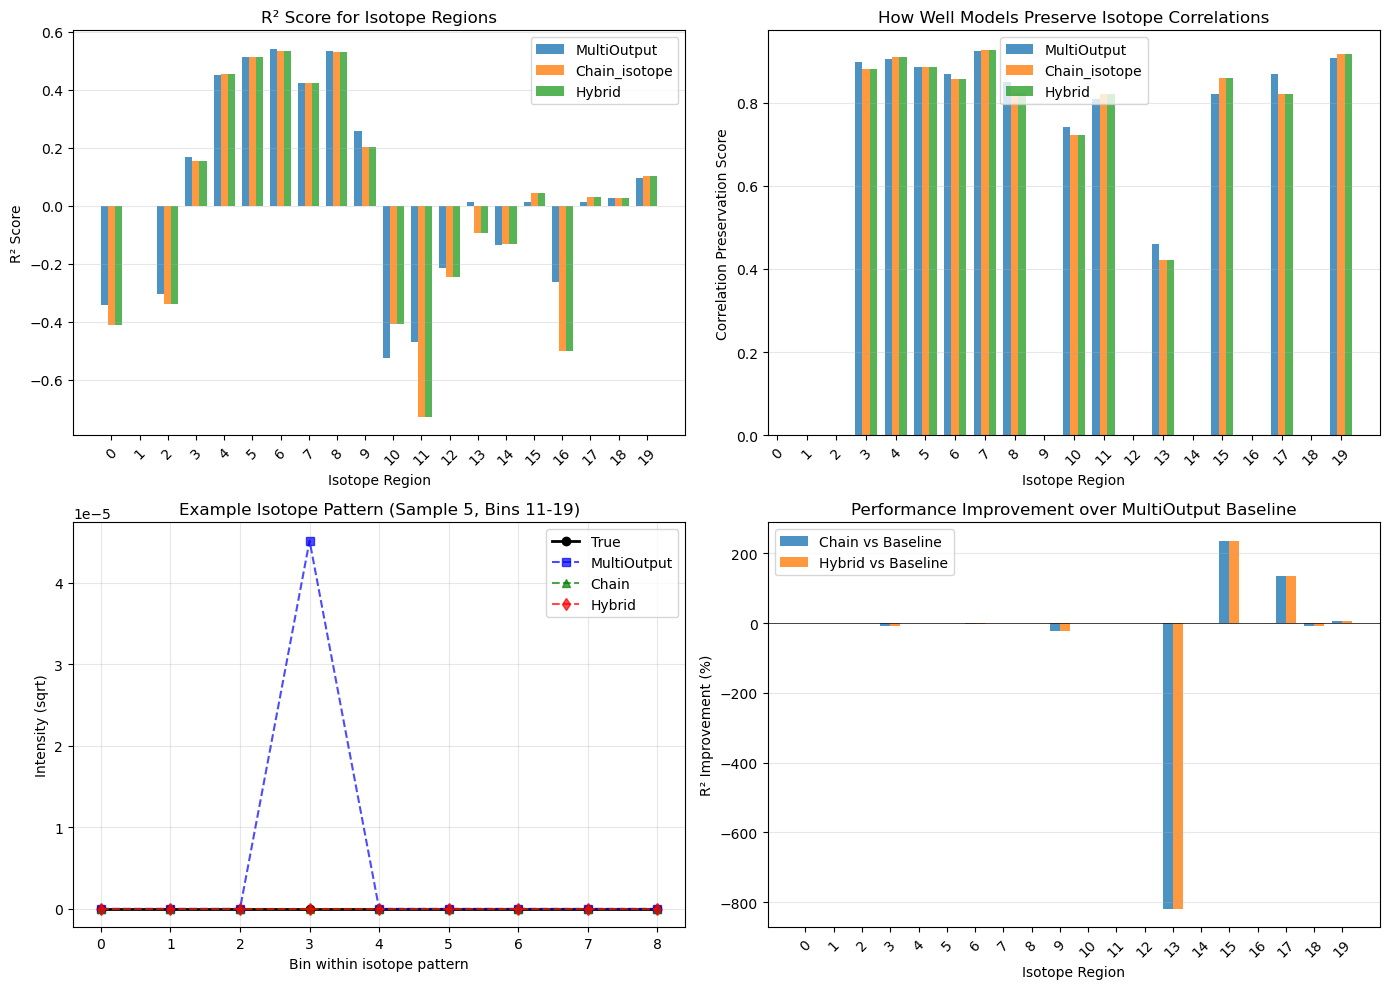

In [9]:
def analyze_isotope_region_performance(y_true, y_pred_dict, isotope_groups):
    """Analyze performance specifically on isotope regions."""
    results = {}
    
    # Analyze each isotope group
    for i, group in enumerate(isotope_groups):
        group_results = {}
        
        # Extract predictions for this group
        y_true_group = y_true[:, group]
        
        for model_name, y_pred in y_pred_dict.items():
            y_pred_group = y_pred[:, group]
            
            # Calculate metrics
            if np.var(y_true_group) > 0:
                r2_group = r2_score(y_true_group, y_pred_group)
                mse_group = mean_squared_error(y_true_group, y_pred_group)
                
                # Calculate correlation preservation
                # Check if the model preserves the correlation structure
                true_corr = np.corrcoef(y_true_group.T)
                pred_corr = np.corrcoef(y_pred_group.T)
                
                # Correlation preservation score (how well correlations are maintained)
                corr_preservation = 1 - np.mean(np.abs(true_corr - pred_corr))
            else:
                r2_group = 0.0
                mse_group = 0.0
                corr_preservation = 0.0
            
            group_results[model_name] = {
                'r2': r2_group,
                'mse': mse_group,
                'corr_preservation': corr_preservation
            }
        
        results[f'Group_{i}_bins_{min(group)}-{max(group)}'] = group_results
    
    return results

# Prepare predictions
isotope_pred_dict = {
    'MultiOutput': results_dict['MultiOutput']['predictions'],
    'Chain_isotope': results_dict['Chain_isotope']['predictions'],
    'Hybrid': results_dict['Hybrid']['predictions']
}

# Analyze isotope regions
isotope_results = analyze_isotope_region_performance(
    y_test_transformed,
    isotope_pred_dict,
    CONFIG['detected_isotope_groups']
)

# Print results
print("\n" + "=" * 80)
print("ISOTOPE REGION PERFORMANCE ANALYSIS")
print("=" * 80)

for region, results in isotope_results.items():
    print(f"\n{region}:")
    for model, metrics in results.items():
        print(f"  {model}:")
        print(f"    R² = {metrics['r2']:.4f}")
        print(f"    MSE = {metrics['mse']:.4f}")
        print(f"    Correlation preservation = {metrics['corr_preservation']:.4f}")

# Visualize isotope region performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. R² scores for isotope regions
ax1 = axes[0, 0]
models = list(isotope_pred_dict.keys())
regions = list(isotope_results.keys())
n_models = len(models)
n_regions = len(regions)

x = np.arange(n_regions)
width = 0.25

for i, model in enumerate(models):
    r2_scores = [isotope_results[region][model]['r2'] for region in regions]
    ax1.bar(x + i*width, r2_scores, width, label=model, alpha=0.8)

ax1.set_xlabel('Isotope Region')
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score for Isotope Regions')
ax1.set_xticks(x + width)
ax1.set_xticklabels([r.split('_')[1] for r in regions], rotation=45)
ax1.legend()
ax1.grid(True, axis='y', alpha=0.3)

# 2. Correlation preservation
ax2 = axes[0, 1]
for i, model in enumerate(models):
    corr_scores = [isotope_results[region][model]['corr_preservation'] for region in regions]
    ax2.bar(x + i*width, corr_scores, width, label=model, alpha=0.8)

ax2.set_xlabel('Isotope Region')
ax2.set_ylabel('Correlation Preservation Score')
ax2.set_title('How Well Models Preserve Isotope Correlations')
ax2.set_xticks(x + width)
ax2.set_xticklabels([r.split('_')[1] for r in regions], rotation=45)
ax2.legend()
ax2.grid(True, axis='y', alpha=0.3)

# 3. Example isotope pattern (bins 11-19)
ax3 = axes[1, 0]
sample_idx = 5  # Example sample
isotope_bins = list(range(11, 20))

true_pattern = y_test_transformed[sample_idx, isotope_bins]
mo_pattern = y_pred_mo[sample_idx, isotope_bins]
chain_pattern = y_pred_chain[sample_idx, isotope_bins]
hybrid_pattern = y_pred_hybrid[sample_idx, isotope_bins]

x_bins = np.arange(len(isotope_bins))
ax3.plot(x_bins, true_pattern, 'k-', linewidth=2, label='True', marker='o')
ax3.plot(x_bins, mo_pattern, 'b--', linewidth=1.5, label='MultiOutput', marker='s', alpha=0.7)
ax3.plot(x_bins, chain_pattern, 'g--', linewidth=1.5, label='Chain', marker='^', alpha=0.7)
ax3.plot(x_bins, hybrid_pattern, 'r--', linewidth=1.5, label='Hybrid', marker='d', alpha=0.7)

ax3.set_xlabel('Bin within isotope pattern')
ax3.set_ylabel('Intensity (sqrt)')
ax3.set_title(f'Example Isotope Pattern (Sample {sample_idx}, Bins 11-19)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Performance improvement over baseline
ax4 = axes[1, 1]
improvements = []
labels = []

for region in regions:
    mo_r2 = isotope_results[region]['MultiOutput']['r2']
    chain_r2 = isotope_results[region]['Chain_isotope']['r2']
    hybrid_r2 = isotope_results[region]['Hybrid']['r2']
    
    if mo_r2 > 0:
        chain_imp = ((chain_r2 - mo_r2) / mo_r2) * 100
        hybrid_imp = ((hybrid_r2 - mo_r2) / mo_r2) * 100
    else:
        chain_imp = 0
        hybrid_imp = 0
    
    improvements.append([chain_imp, hybrid_imp])
    labels.append(region.split('_')[1])

improvements = np.array(improvements)
x = np.arange(len(labels))
width = 0.35

ax4.bar(x - width/2, improvements[:, 0], width, label='Chain vs Baseline', alpha=0.8)
ax4.bar(x + width/2, improvements[:, 1], width, label='Hybrid vs Baseline', alpha=0.8)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax4.set_xlabel('Isotope Region')
ax4.set_ylabel('R² Improvement (%)')
ax4.set_title('Performance Improvement over MultiOutput Baseline')
ax4.set_xticks(x)
ax4.set_xticklabels(labels, rotation=45)
ax4.legend()
ax4.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()